In [150]:
import math
import numpy as np
import os
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import stft
from scipy.fft import fft
from glob import glob
   
""" Parameters to enhance figure visibility and to rescale figures. """
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams['font.size'] = 14



In [2]:
""" Walks the OS and reads the datapath of all recorded files. """

_datapaths = glob('/home/johannes.waltmann/johannes_waltmann_bachelor_thesis/Data_Analysis/All Data edited/*wav')



In [3]:
def fast_fourier_transform(data):
    """
    Applies a fast fourier transformation to a given chunk of data.

    :param data: Array of raw data from a wav-sample

    :returns: Input data as transformed by the FFT.
    """
    _transformed_data = fft(data)
    return np.abs(_transformed_data[:int((len(_transformed_data)/2)-1)])



In [4]:
def short_term_fourier_transform(data):
    """
    Apply the short-term-fourier-transformation to the wav data.

    :param data: Data from a wav sample as an array.

    :returns: The input data after the stft.
    """
    return np.abs(lb.stft(data))



In [5]:
def compute_mfcc(audio_data, samplerate):
    """
    Computes the mel frequency coefficient for a given audio sample.
    
    :param audio_data: Array containing audiodata.
    :param samplerate: The samplerate which is relating to the given audio_data.
    
    :returns: The mfcc for the auido_data as a numpy array.
    """
    return lb.feature.mfcc(y=audio_data, sr=samplerate)



In [6]:
""" Extracts samplerate and audio data per file and computes fft  and stft. Saves data and sample info to dataframe. """

_dataset = []

for d in tqdm(_datapaths):

    wav_data, samplerate = lb.load(d)

    _stft = short_term_fourier_transform(wav_data)
    _fft = fast_fourier_transform(wav_data)
    _mfcc = compute_mfcc(wav_data, samplerate)


    _dataset.append({'path': d,
                    'pid': int(os.path.basename(d).split('_')[1].replace('p', '')),
                    'session': int(os.path.basename(d).split('_')[2].replace('s', '')),
                    'location': os.path.basename(d).split('_')[3],
                    'stimulus_type': os.path.basename(d).split('_')[4],
                    'repetition': os.path.basename(d).split('_')[5].replace('.wav', ''),
                    'samplerate': samplerate,
                    'wav': wav_data,
                    'stft': _stft,
                    'fft': _fft,
                     'mfcc': _mfcc
                     })



100%|██████████| 2520/2520 [10:01<00:00,  4.19it/s]


In [195]:
""" Defines Parameters for eval. Pipeline. """

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import Binarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

n_neighbors = 1 # defaults to 5, 1 taken by skull conduct
metric = 'euclidean'
weights = 'distance' # distance or uniform

n_estimators = 1000 # defaults to 100


In [189]:
"""PRINTS KNN"""
for t in ['stft', 'fft', 'mfcc']:
    for stimulus in ['m', 'r', 'wn']:
        for position in ['w', 'a', 'h']:

            x_train = np.array([d[t].flatten() for d in _dataset
                                 if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            x_val = np.array([d[t].flatten() for d in _dataset
                                 if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_train  = np.array([d['pid'] for d in _dataset
                                  if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_val  = np.array([d['pid'] for d in _dataset
                                  if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            clf = KNeighborsClassifier(metric=metric, weights=weights)
            
            clf.fit(x_train, y_train)

            y_pred = clf.predict(x_val)
            labels = ["p0", "p1", "p2", "p3", "p4", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13"]
            lbs= [0,1,2,3,4,6,7,8,9,10,11,12,13]
            report = classification_report(y_val, y_pred)
            cm = confusion_matrix(y_val, y_pred)


            print(stimulus, position, t)


            print(report)
            print(cm)



            df_cm = pd.DataFrame(cm, index = labels, columns = labels)
            plt.figure(figsize= (13,13))
            sn_plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
            plt.title(f'cm_kNN_{t}_{stimulus}_{position}')
            plt.xlabel("True Label")
            plt.ylabel("Predicted Label")
            plt.tight_layout(pad=0.2)

            plt.savefig(f'./Plots/Confusion Matrix/cm_kNN_{t}_{stimulus}_{position}.pdf')
            plt.show()
        

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m w stft
Accurancy:  8.4615%
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      1.00      1.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.29      0.20      0.24        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.13      0.30      0.18        10
          13       0.38      1.00      0.56        10

    accuracy                           0.27       130
   macro avg       0.18      0.27      0.20       130
weighted avg       0.18      0.27      0.20       130

[[10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m a stft
Accurancy:  3.8462%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.60      0.60      0.60        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.90      0.95        10
          11       0.25      0.10      0.14        10
          12       0.48      1.00      0.65        10
          13       0.00      0.00      0.00        10

    accuracy                           0.20       130
   macro avg       0.18      0.20      0.18       130
weighted avg       0.18      0.20      0.18       130

[[ 0  0  1  1  0  0  0  0  0  0  3  5  0]
 [ 5  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r w stft
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.73      0.80      0.76        10
           4       0.33      0.10      0.15        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.05      0.10      0.06        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.11      0.60      0.18        10
          13       0.25      0.30      0.27        10

    accuracy                           0.15       130
   macro avg       0.11      0.15      0.11       130
weighted avg       0.11      0.15      0.11       130

[[0 6 0 0 0 0 0 1 0 0 0 3 0]
 [1 0 2 0 0 0 0 4 0 0

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r a stft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.16      0.60      0.26        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.50      0.20      0.29        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      0.10      0.15        10
          11       0.08      0.10      0.09        10
          12       0.09      0.50      0.15        10
          13       0.00      0.00      0.00        10

    accuracy                           0.12       130
   macro avg       0.09      0.12      0.07       130
weighted avg       0.09      0.12      0.07       130

[[0 0 3 0 0 0 0 0 0 0 4 3 0]
 [0 0 0 0 0 0 0 0 0 0

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r h stft
Accurancy:  9.2308%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.43      0.30      0.35        10
           2       0.00      0.00      0.00        10
           3       0.50      0.20      0.29        10
           4       1.00      0.30      0.46        10
           6       0.50      0.10      0.17        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.10      0.30      0.15        10
          13       0.00      0.00      0.00        10

    accuracy                           0.09       130
   macro avg       0.19      0.09      0.11       130
weighted avg       0.19      0.09      0.11       130

[[0 0 0 0 0 0 0 0 0 0 0 3 7]
 [0 3 0 0 0 0 0 0 0 0

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn w stft
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.33      0.10      0.15        10
           2       0.20      0.10      0.13        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.38      0.30      0.33        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.12      1.00      0.21        10
          13       0.00      0.00      0.00        10

    accuracy                           0.12       130
   macro avg       0.09      0.12      0.07       130
weighted avg       0.09      0.12      0.07       130

[[ 1  0  1  0  0  0  0  0  0  0  0  8  0]
 [ 1  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn a stft
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.00      0.00      0.00        10
           2       0.22      0.20      0.21        10
           3       0.00      0.00      0.00        10
           4       0.64      0.90      0.75        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.40      0.57        10
          11       0.00      0.00      0.00        10
          12       0.13      1.00      0.24        10
          13       0.00      0.00      0.00        10

    accuracy                           0.21       130
   macro avg       0.18      0.21      0.16       130
weighted avg       0.18      0.21      0.16       130

[[ 2  0  0  0  0  0  0  0  0  0  0  8  0]
 [ 2  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn h stft
Accurancy:  6.1538%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      0.20      0.31        10
           2       0.00      0.00      0.00        10
           3       0.33      0.10      0.15        10
           4       0.18      0.20      0.19        10
           6       0.25      0.10      0.14        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.42      1.00      0.59        10
          11       0.00      0.00      0.00        10
          12       0.09      0.10      0.10        10
          13       0.15      0.80      0.25        10

    accuracy                           0.19       130
   macro avg       0.16      0.19      0.13       130
weighted avg       0.16      0.19      0.13       130

[[ 0  0  0  0  0  0  0  0  0  0  0  6  4]
 [ 7  2

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m w fft
Accurancy:  8.4615%
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      0.70      0.82        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.88      0.70      0.78        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.20      0.50      0.29        10
          13       0.43      1.00      0.61        10

    accuracy                           0.30       130
   macro avg       0.23      0.30      0.24       130
weighted avg       0.23      0.30      0.24       130

[[10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  7  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m a fft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.06      0.10      0.07        10
           1       0.00      0.00      0.00        10
           2       0.13      0.60      0.22        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.82      0.90      0.86        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.10      0.18        10
          11       0.17      0.20      0.18        10
          12       0.56      1.00      0.71        10
          13       0.00      0.00      0.00        10

    accuracy                           0.22       130
   macro avg       0.21      0.22      0.17       130
weighted avg       0.21      0.22      0.17       130

[[ 1  0  0  2  0  0  0  0  0  0  4  3  0]
 [ 5  0  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m h fft
Accurancy:  6.1538%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.62      1.00      0.77        10
           2       0.05      0.10      0.07        10
           3       0.00      0.00      0.00        10
           4       0.67      0.20      0.31        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.73      0.80      0.76        10
          11       0.00      0.00      0.00        10
          12       0.16      0.50      0.24        10
          13       0.00      0.00      0.00        10

    accuracy                           0.20       130
   macro avg       0.17      0.20      0.17       130
weighted avg       0.17      0.20      0.17       130

[[ 0  0  0  0  0  0  0  0  0  0  2  8  0]
 [ 0 10  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r w fft
Accurancy:  5.3846%
              precision    recall  f1-score   support

           0       0.08      0.10      0.09        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.73      0.80      0.76        10
           4       0.67      0.40      0.50        10
           6       1.00      0.20      0.33        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.25      0.40      0.31        10

    accuracy                           0.15       130
   macro avg       0.21      0.15      0.15       130
weighted avg       0.21      0.15      0.15       130

[[ 1  9  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r a fft
Accurancy:  6.1538%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.23      0.90      0.36        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.27      0.40      0.32        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.50      0.67        10
          11       0.20      0.70      0.31        10
          12       1.00      0.60      0.75        10
          13       0.00      0.00      0.00        10

    accuracy                           0.24       130
   macro avg       0.21      0.24      0.19       130
weighted avg       0.21      0.24      0.19       130

[[ 0  0  0  0  0  0  1  0  0  0  9  0  0]
 [ 0  0  

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r h fft
Accurancy:  11.5385%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.59      1.00      0.74        10
           2       0.00      0.00      0.00        10
           3       0.33      0.20      0.25        10
           4       0.33      0.10      0.15        10
           6       0.43      0.30      0.35        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.50      0.10      0.17        10
          11       0.00      0.00      0.00        10
          12       0.04      0.20      0.07        10
          13       0.00      0.00      0.00        10

    accuracy                           0.15       130
   macro avg       0.17      0.15      0.13       130
weighted avg       0.17      0.15      0.13       130

[[ 0  1  0  0  0  0  0  0  0  0  0  9  0]
 [ 0 10 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn w fft
Accurancy:  8.4615%
              precision    recall  f1-score   support

           0       0.31      0.50      0.38        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.40      0.40      0.40        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.67      0.20      0.31        10
          12       0.16      1.00      0.28        10
          13       0.00      0.00      0.00        10

    accuracy                           0.16       130
   macro avg       0.12      0.16      0.11       130
weighted avg       0.12      0.16      0.11       130

[[ 5  0  0  0  0  0  0  0  0  0  0  5  0]
 [ 9  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn a fft
Accurancy:  9.2308%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.18      0.80      0.29        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.38      0.50      0.43        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.29      1.00      0.45        10
          13       0.00      0.00      0.00        10

    accuracy                           0.18       130
   macro avg       0.07      0.18      0.09       130
weighted avg       0.07      0.18      0.09       130

[[ 0  0  0  0  1  0  0  0  0  0  8  1  0]
 [ 1  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/

wn h fft
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      0.20      0.29        10
           2       0.00      0.00      0.00        10
           3       0.50      0.10      0.17        10
           4       0.29      0.40      0.33        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.38      1.00      0.56        10
          11       0.00      0.00      0.00        10
          12       0.07      0.30      0.12        10
          13       0.00      0.00      0.00        10

    accuracy                           0.15       130
   macro avg       0.13      0.15      0.11       130
weighted avg       0.13      0.15      0.11       130

[[ 0  1  1  0  0  0  0  0  0  0  0  8  0]
 [ 8  2 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m w fft
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       0.75      0.30      0.43        10
           2       0.18      0.20      0.19        10
           3       0.86      0.60      0.71        10
           4       0.00      0.00      0.00        10
           6       0.36      0.40      0.38        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.05      0.10      0.06        10
          13       0.29      0.90      0.44        10

    accuracy                           0.23       130
   macro avg       0.23      0.23      0.21       130
weighted avg       0.23      0.23      0.21       130

[[ 5  1  3  0  0  0  0  0  0  0  0  1  0]
 [ 2  3  4  0  1  0  0  0  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m h fft
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      0.70      0.45        10
           2       0.38      0.30      0.33        10
           3       0.20      0.20      0.20        10
           4       0.75      0.30      0.43        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      1.00      0.50        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.19       130
   macro avg       0.15      0.19      0.15       130
weighted avg       0.15      0.19      0.15       130

[[ 0  2  0  0  0  0  0  0  0  0  6  1  1]
 [ 0  7  2  0  0  0  0  0  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r w fft
              precision    recall  f1-score   support

           0       0.12      0.30      0.18        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.82      0.90      0.86        10
           4       1.00      0.40      0.57        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.47      0.90      0.62        10

    accuracy                           0.19       130
   macro avg       0.19      0.19      0.17       130
weighted avg       0.19      0.19      0.17       130

[[ 3  7  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r a fft
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.50      0.10      0.17        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.31      0.40      0.35        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      1.00      1.00        10
          11       0.00      0.00      0.00        10
          12       0.82      0.90      0.86        10
          13       0.60      0.30      0.40        10

    accuracy                           0.21       130
   macro avg       0.25      0.21      0.21       130
weighted avg       0.25      0.21      0.21       130

[[ 0  1  0  0  2  0  0  0  0  0  7  0  0]
 [ 0  1  0  0  0  0  1  0  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r h fft
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      1.00      0.56        10
           2       0.00      0.00      0.00        10
           3       0.50      0.40      0.44        10
           4       0.80      0.40      0.53        10
           6       0.62      0.50      0.56        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      1.00      0.50        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.25       130
   macro avg       0.20      0.25      0.20       130
weighted avg       0.20      0.25      0.20       130

[[ 0  0  0  0  0  0  0  0  0  0  1  9  0]
 [ 0 10  0  0  0  0  0  0  0 

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn w fft
              precision    recall  f1-score   support

           0       0.25      0.30      0.27        10
           1       0.56      0.50      0.53        10
           2       0.00      0.00      0.00        10
           3       0.33      0.10      0.15        10
           4       0.00      0.00      0.00        10
           6       0.33      0.30      0.32        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.09       130
   macro avg       0.11      0.09      0.10       130
weighted avg       0.11      0.09      0.10       130

[[ 3  0  0  0  0  0  0  0  0  0  0  7  0]
 [ 3  5  2  0  0  0  0  0  0

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn h fft
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.33      0.40      0.36        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.38      0.50      0.43        10
           6       0.50      0.10      0.17        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      1.00      0.50        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.15       130
   macro avg       0.12      0.15      0.11       130
weighted avg       0.12      0.15      0.11       130

[[ 0  2  3  0  0  0  0  0  0  0  0  4  1]
 [ 6  4  0  0  0  0  0  0  0

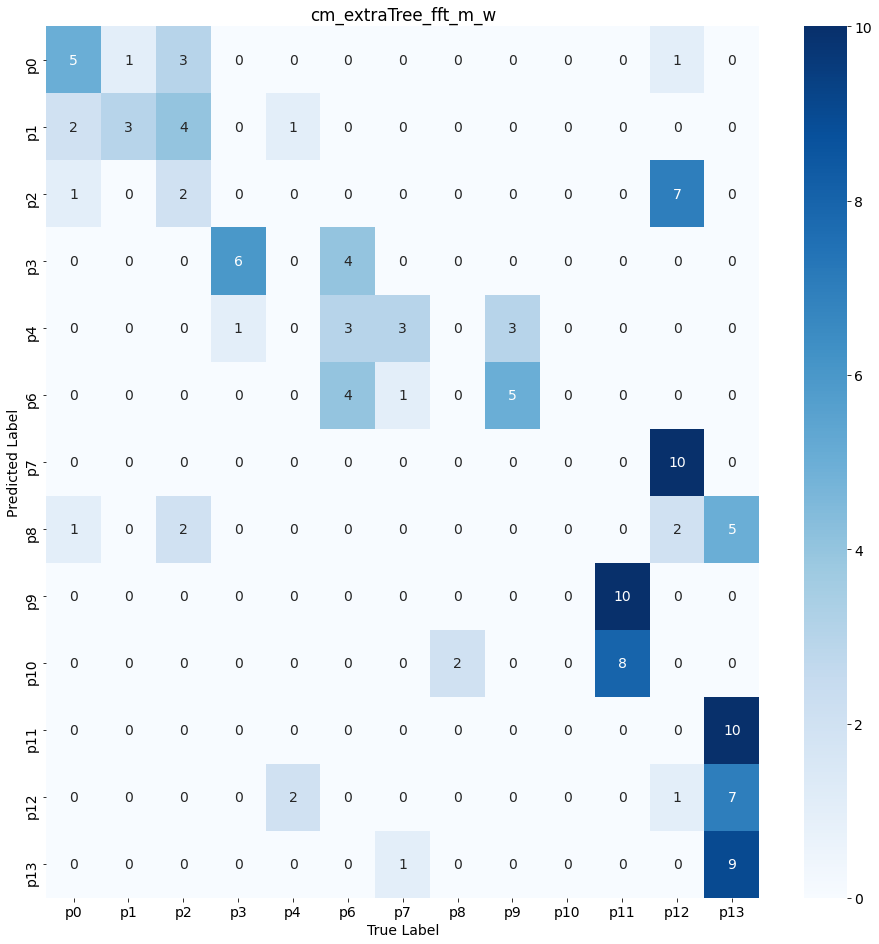

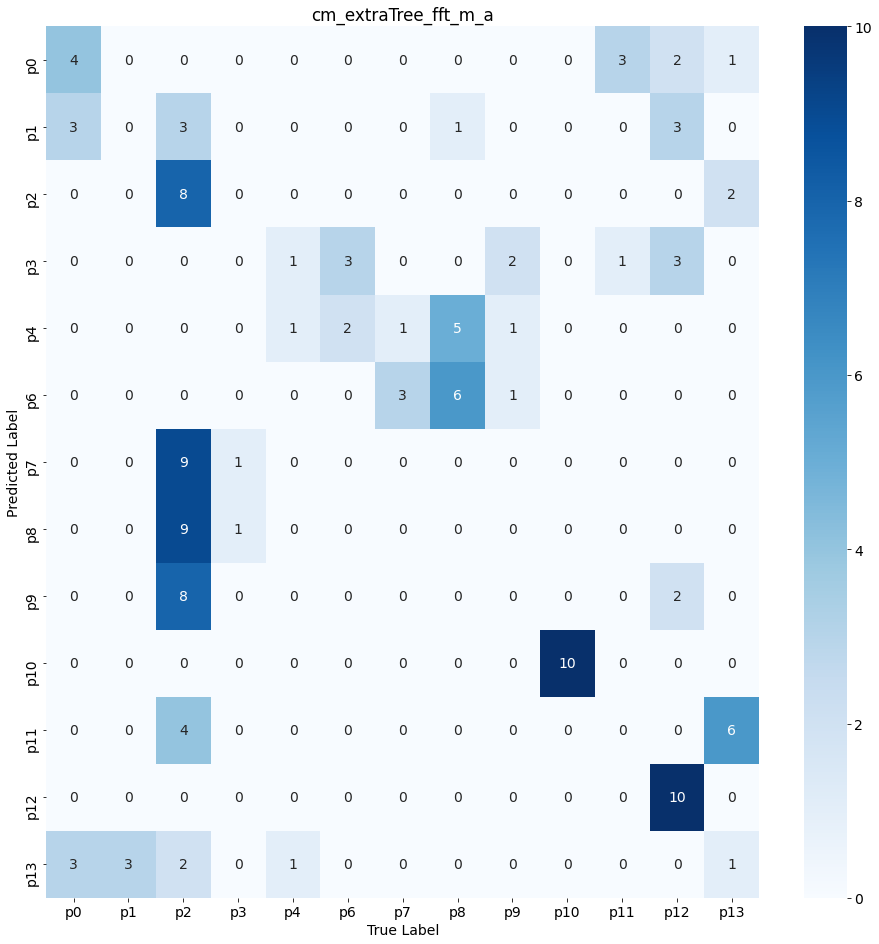

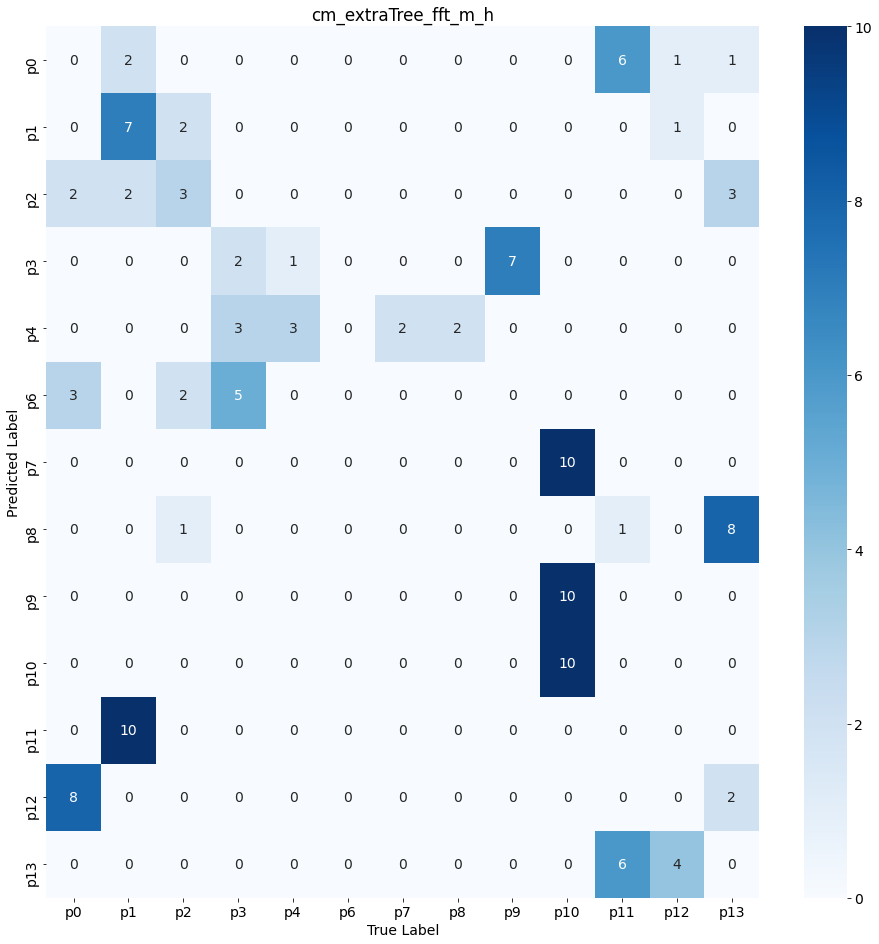

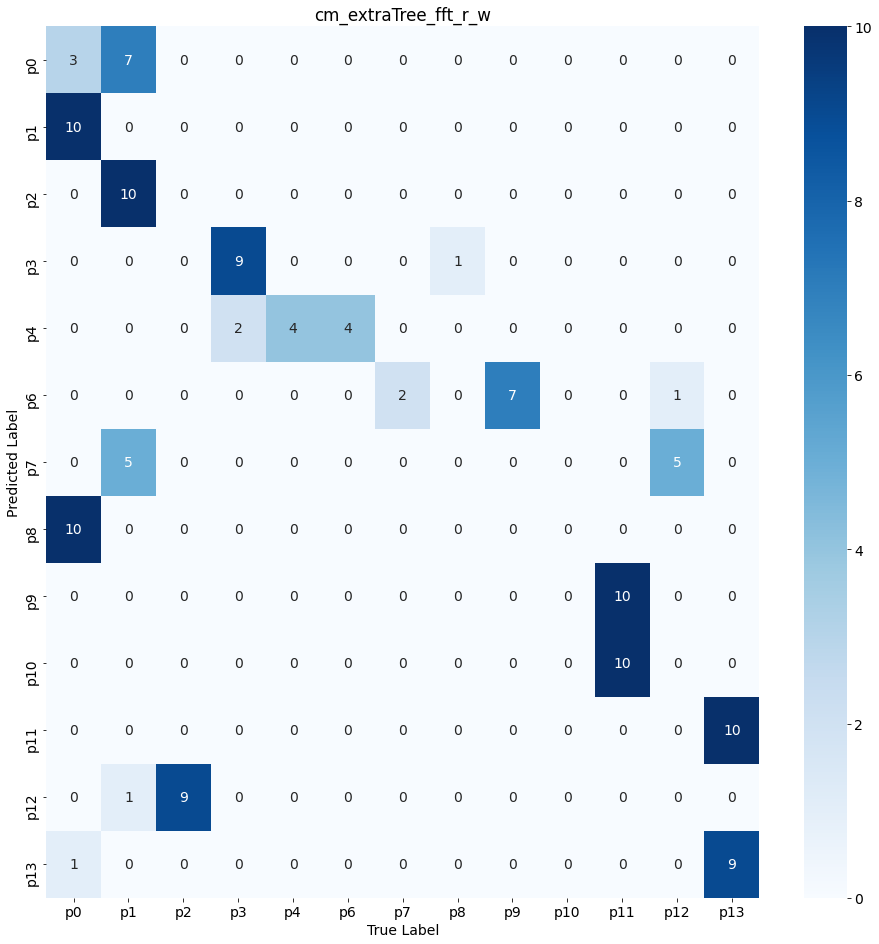

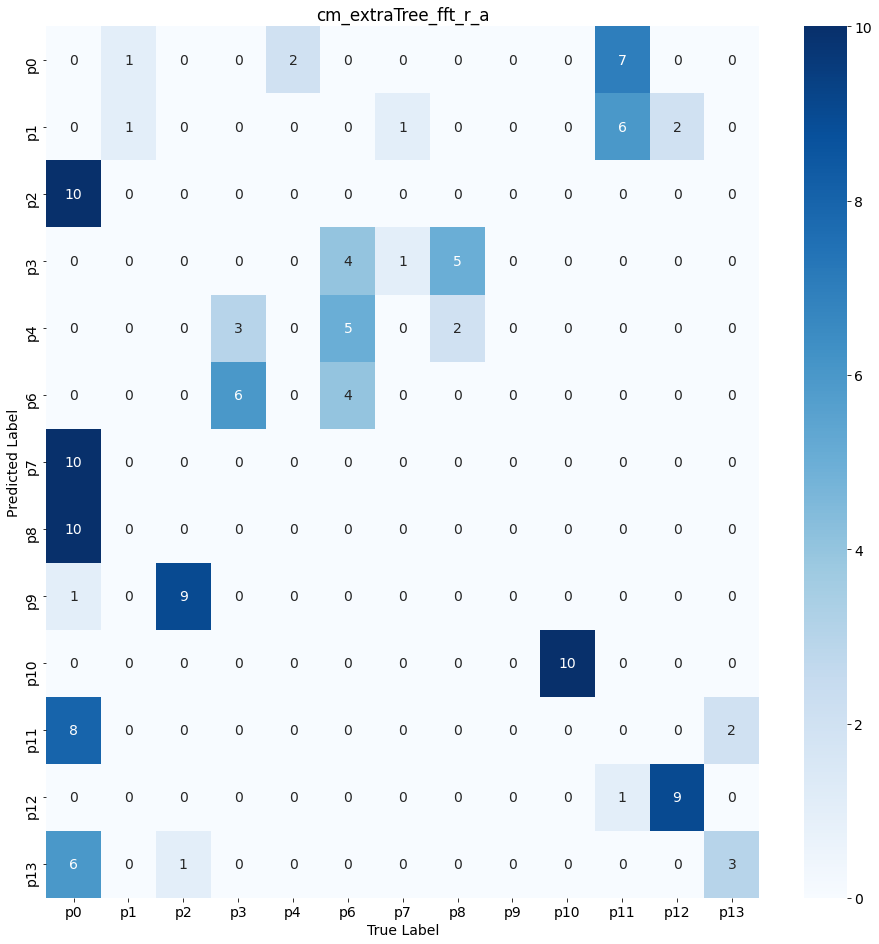

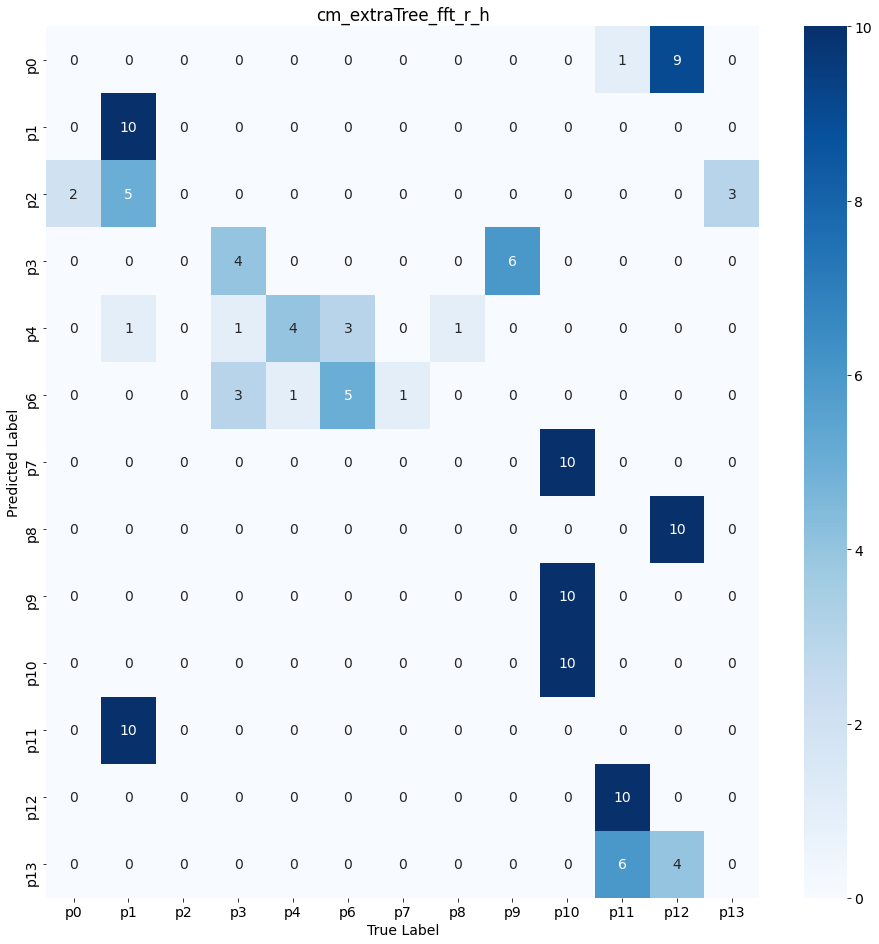

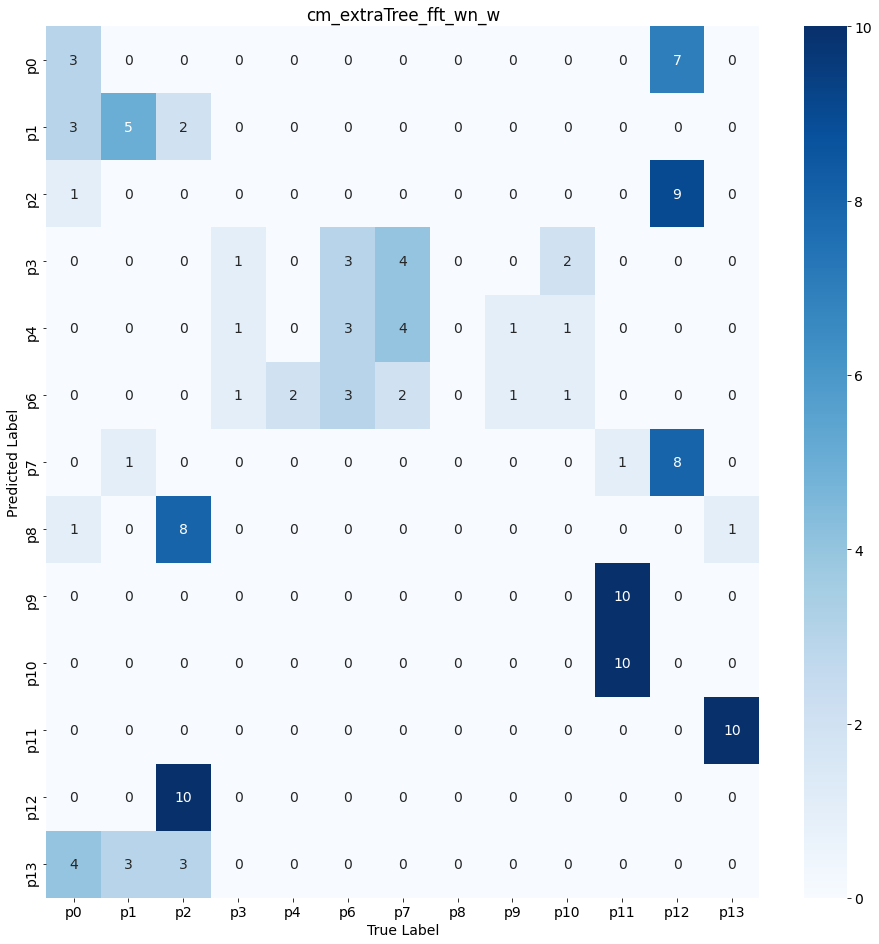

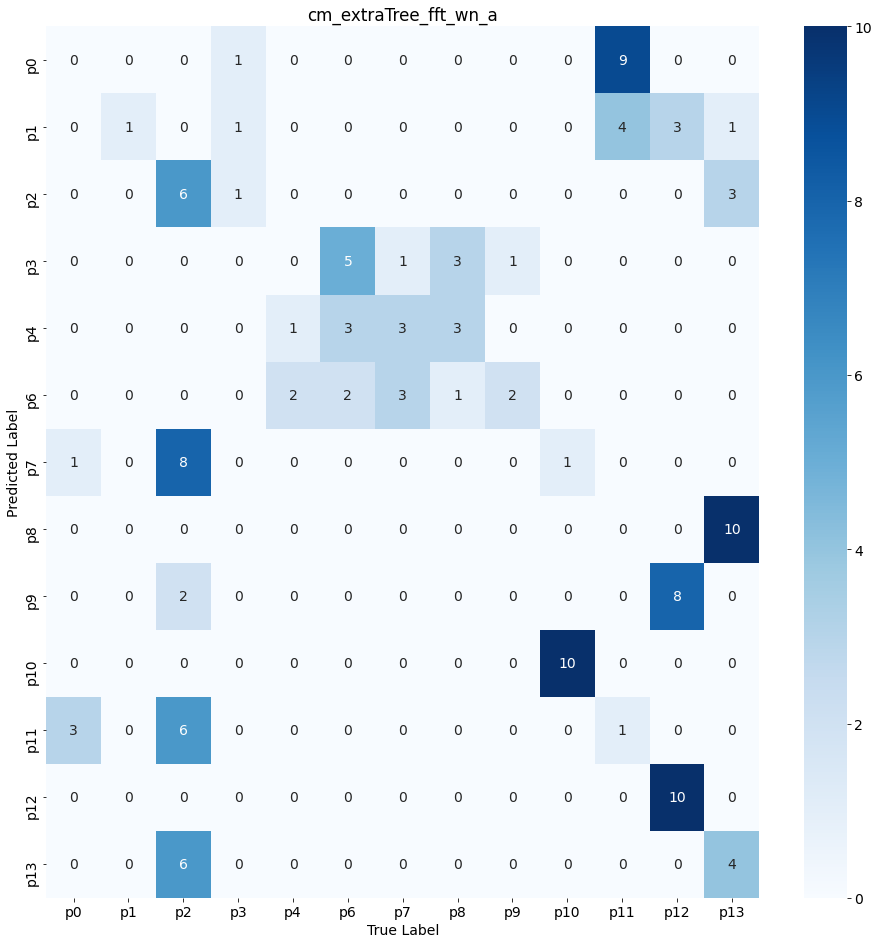

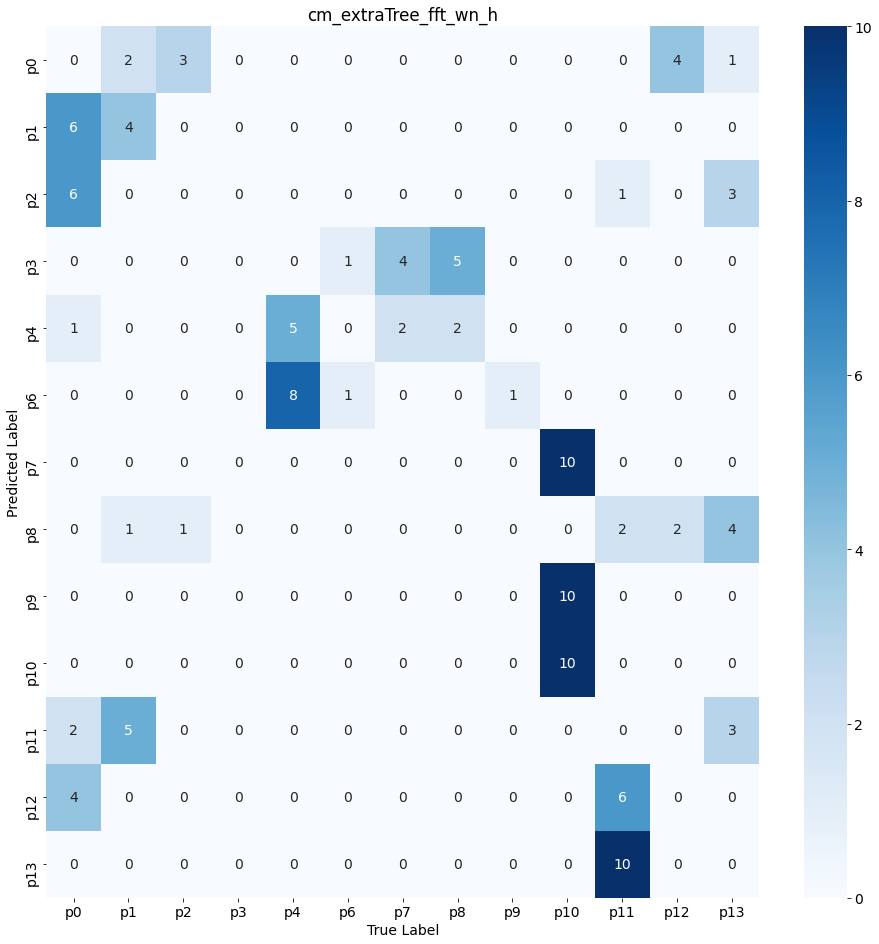

In [187]:
"""USES EXTREE"""
for t in ['stft', 'fft', 'mfcc']:
    for stimulus in ['m', 'r', 'wn']:
        for position in ['w', 'a', 'h']:

            x_train = np.array([d[t].flatten() for d in _dataset
                             if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            x_val = np.array([d[t].flatten() for d in _dataset
                             if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_train  = np.array([d['pid'] for d in _dataset
                              if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_val  = np.array([d['pid'] for d in _dataset
                              if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=0)
            
            clf.fit(x_train, y_train)

            y_pred = clf.predict(x_val)

            report = classification_report(y_val, y_pred)
            cm = confusion_matrix(y_val, y_pred)

            print(stimulus, position, t)

            print(report)
            print(cm)
        
            labels = ["p0", "p1", "p2", "p3", "p4", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13"]
        
            df_cm = pd.DataFrame(cm, index = labels, columns = labels)
            plt.figure(figsize= (13,13))
            sn_plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
            plt.title(f'cm_extraTree_{t}_{stimulus}_{position}')
            plt.xlabel("True Label")
            plt.ylabel("Predicted Label")
            plt.tight_layout(pad=0.2)
            plt.savefig(f'./Plots/Confusion Matrix/cm_extraTree_{t}_{stimulus}_{position}.pdf')
            plt.show()


/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m w stft
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.14      0.40      0.21        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       1.00      0.40      0.57        10
           4       0.00      0.00      0.00        10
           6       0.29      0.40      0.33        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.03      0.10      0.05        10
          13       0.25      0.80      0.38        10

    accuracy                           0.16       130
   macro avg       0.13      0.16      0.12       130
weighted avg       0.13      0.16      0.12       130

[[ 4  0  0  0  0  0  0  0  0  0  0  6  0]
 [10  0

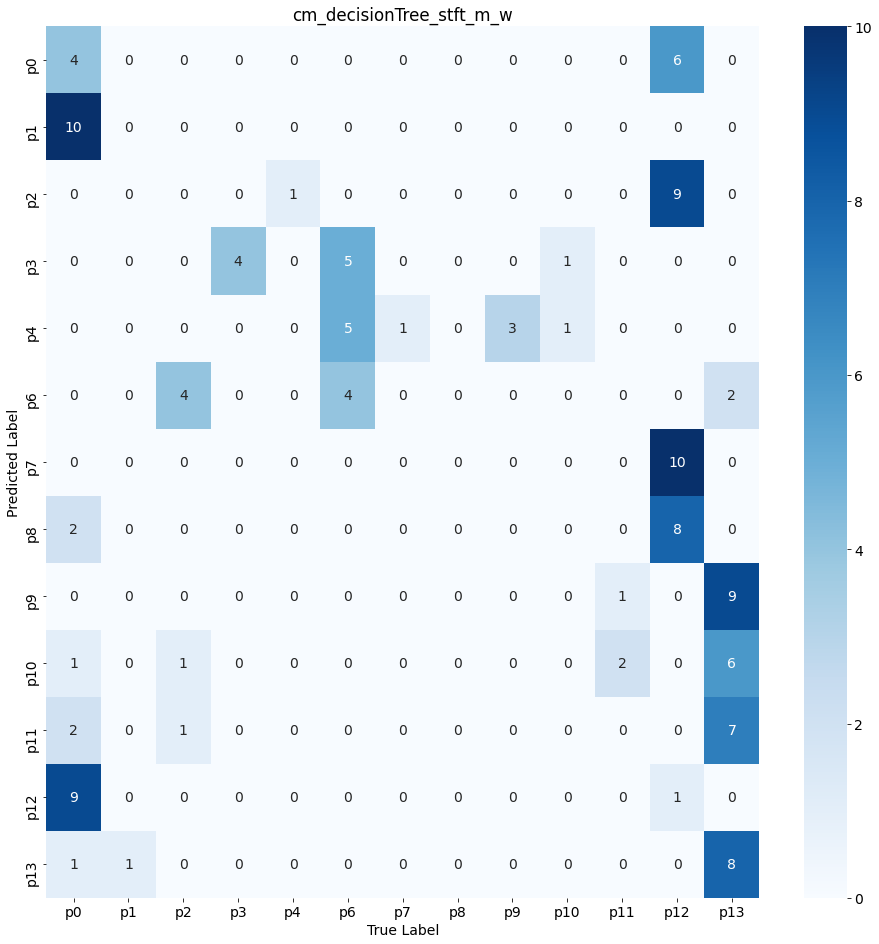

m a stft
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.00      0.00      0.00        10
           2       0.05      0.10      0.06        10
           3       0.14      0.10      0.12        10
           4       0.27      0.30      0.29        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.90      0.95        10
          11       0.00      0.00      0.00        10
          12       0.33      0.30      0.32        10
          13       0.24      0.70      0.36        10

    accuracy                           0.19       130
   macro avg       0.18      0.19      0.17       130
weighted avg       0.18      0.19      0.17       130

[[1 0 3 2 0 0 0 0 0 0 4 0 0]
 [0 0 4 1 0 0 2 0 0 0

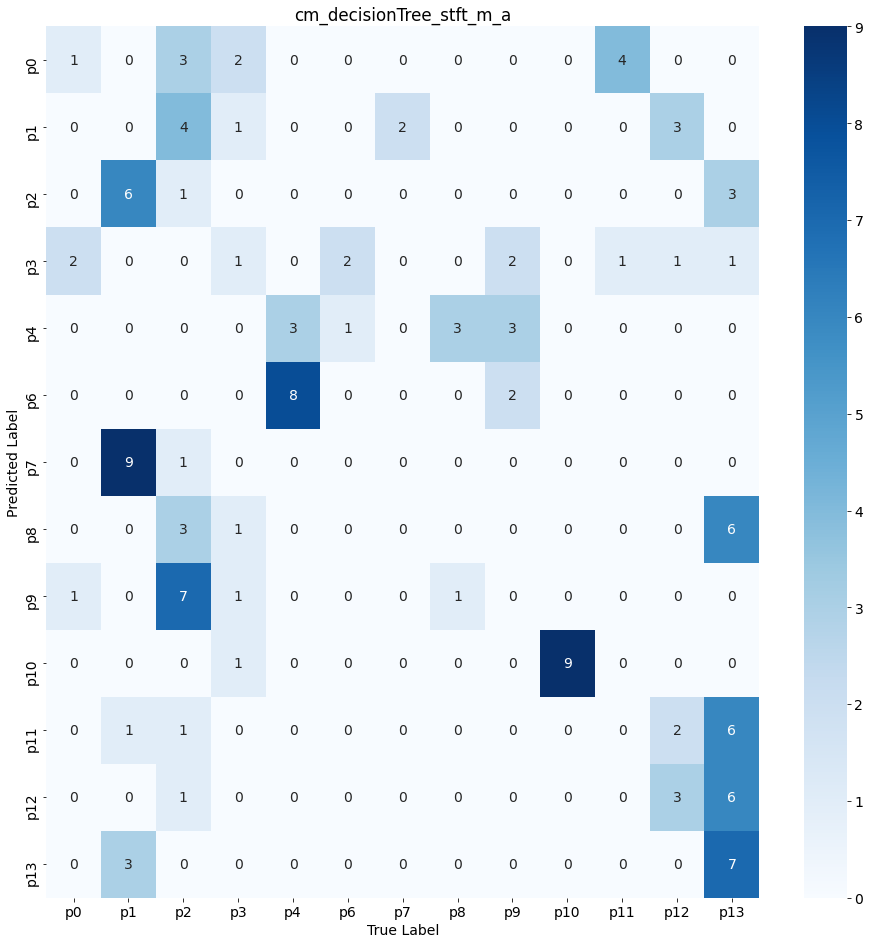

m h stft
Accurancy:  7.6923%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.38      0.60      0.46        10
           2       0.27      0.30      0.29        10
           3       0.00      0.00      0.00        10
           4       0.55      0.60      0.57        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      1.00      0.50        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.06      0.10      0.07        10

    accuracy                           0.20       130
   macro avg       0.12      0.20      0.15       130
weighted avg       0.12      0.20      0.15       130

[[ 0  0  1  0  0  0  0  0  0  0  1  6  2]
 [ 0  6 

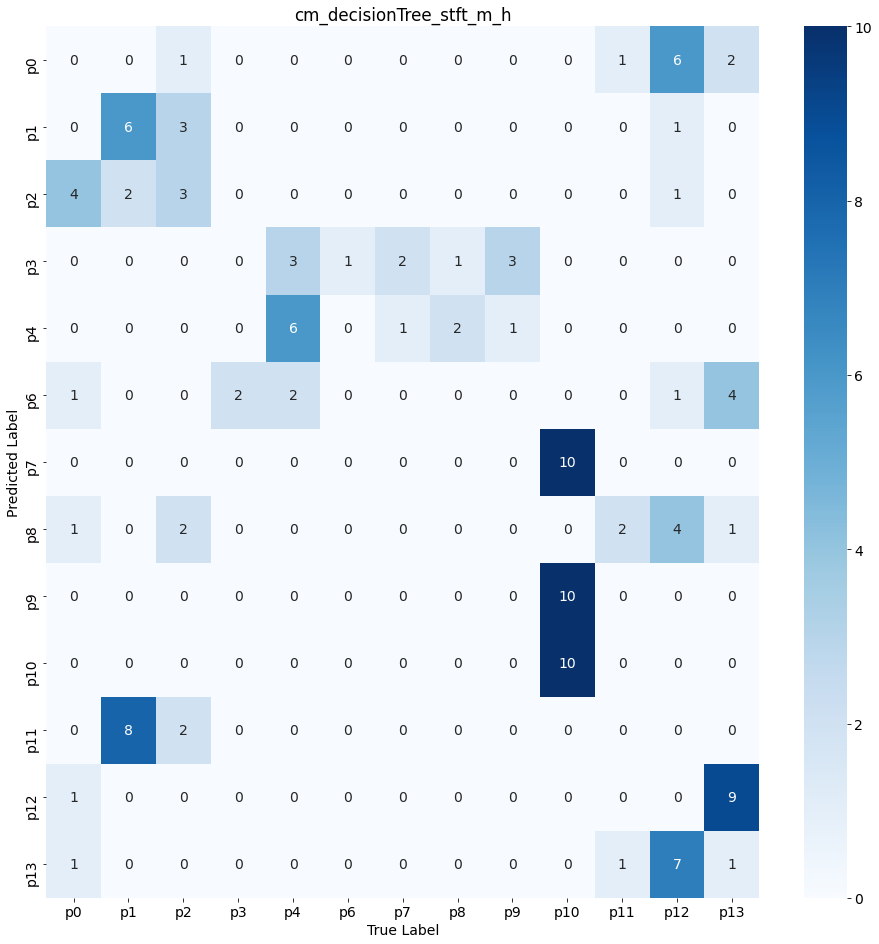

r w stft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.38      0.50      0.43        10
           4       0.25      0.10      0.14        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.06      0.10      0.08        10
           9       0.00      0.00      0.00        10
          10       0.15      0.20      0.17        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.21      0.70      0.32        10

    accuracy                           0.12       130
   macro avg       0.08      0.12      0.09       130
weighted avg       0.08      0.12      0.09       130

[[0 4 0 0 0 0 1 0 1 2 0 0 2]
 [1 0 1 0 1 0 1 4 0 1

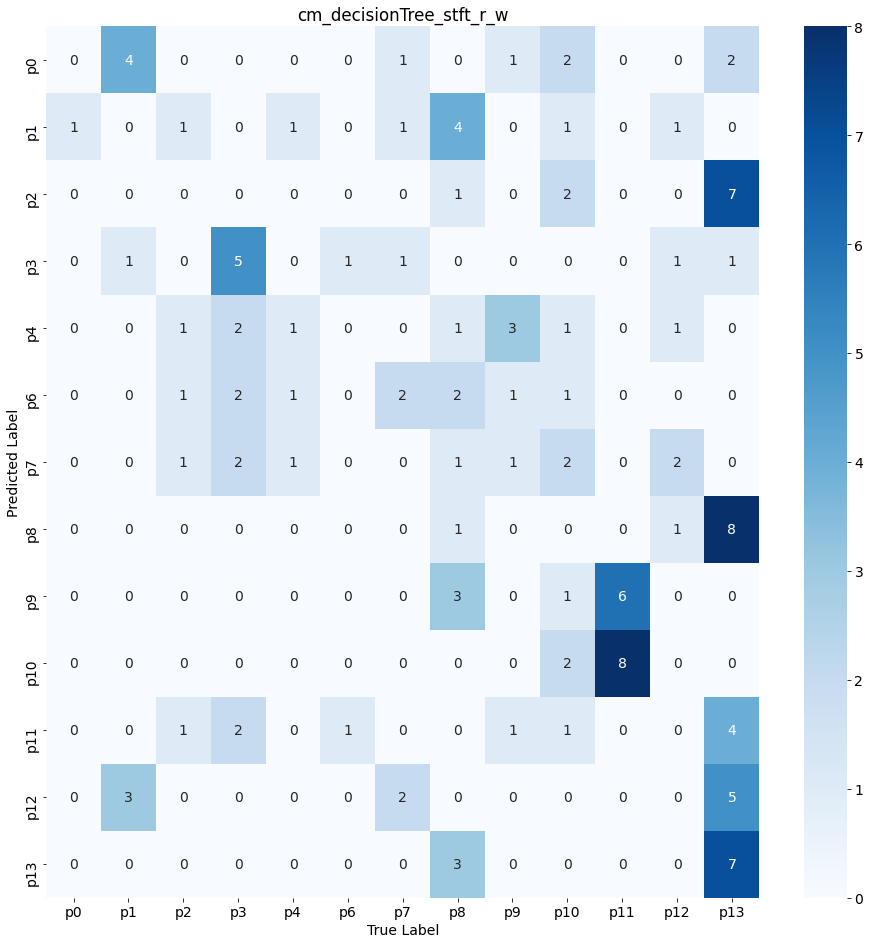

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r a stft
Accurancy:  7.6923%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.14      0.20      0.17        10
           6       0.10      0.10      0.10        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.90      0.95        10
          11       0.14      0.20      0.17        10
          12       0.05      0.10      0.07        10
          13       0.25      0.80      0.38        10

    accuracy                           0.18       130
   macro avg       0.13      0.18      0.14       130
weighted avg       0.13      0.18      0.14       130

[[0 0 5 2 0 1 0 2 0 0 0 0 0]
 [1 0 1 0 2 1 1 2 0 0

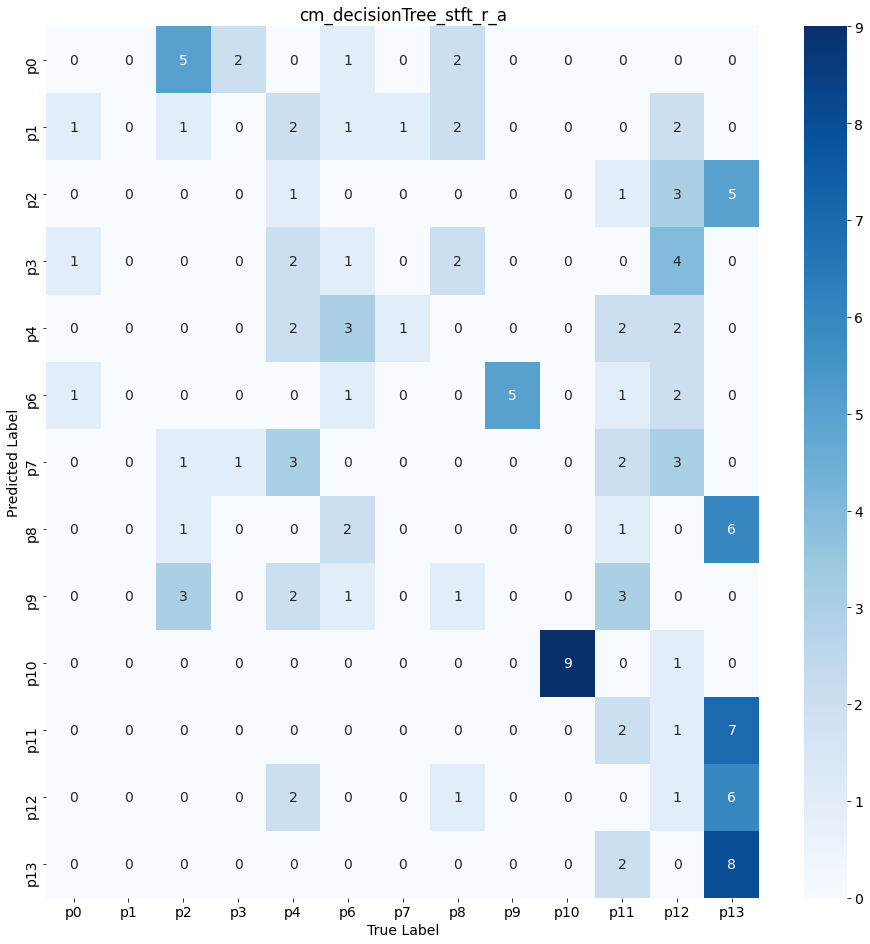

r h stft
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.50      0.20      0.29        10
           4       0.17      0.10      0.12        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.31      1.00      0.48        10
          11       0.42      0.50      0.45        10
          12       0.14      0.10      0.12        10
          13       0.25      0.80      0.38        10

    accuracy                           0.21       130
   macro avg       0.14      0.21      0.14       130
weighted avg       0.14      0.21      0.14       130

[[ 0  0  0  1  1  1  1  4  0  0  0  2  0]
 [ 1  0 

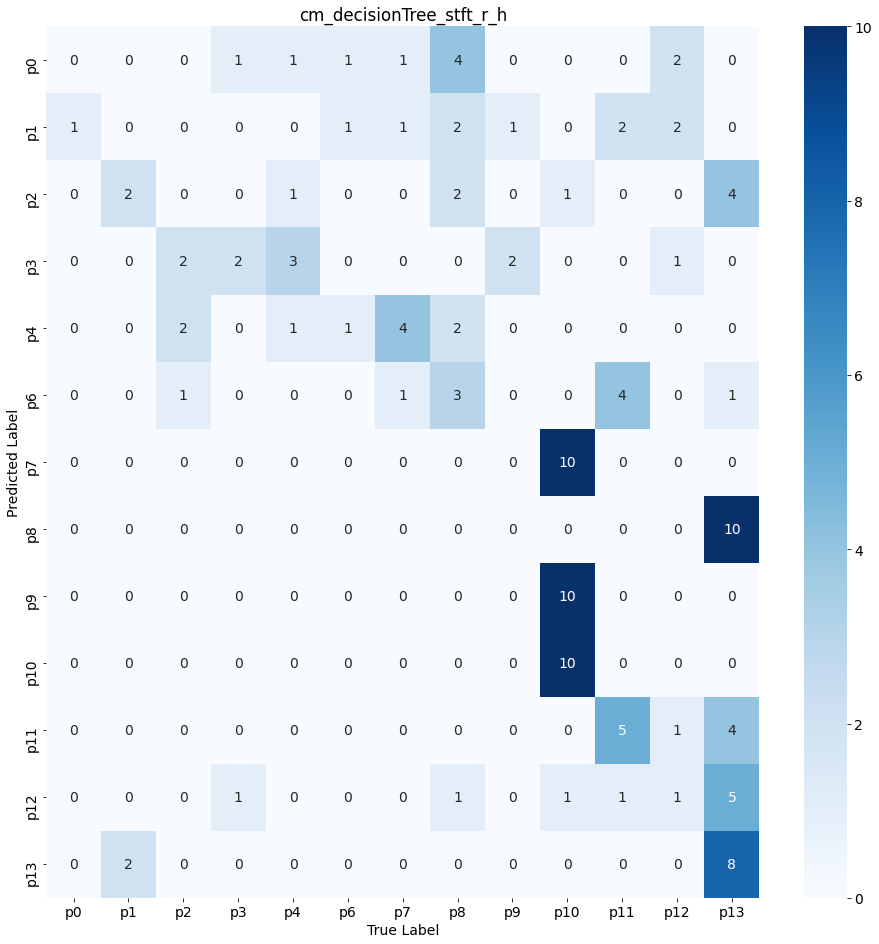

wn w stft
Accurancy:  5.3846%
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.33      0.10      0.15        10
           2       0.09      0.10      0.10        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.40      0.20      0.27        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.04      0.10      0.06        10
          12       0.07      0.10      0.08        10
          13       0.22      0.80      0.34        10

    accuracy                           0.12       130
   macro avg       0.11      0.12      0.09       130
weighted avg       0.11      0.12      0.09       130

[[1 0 2 0 0 0 0 0 0 0 3 3 1]
 [0 1 3 0 0 0 0 0 0 

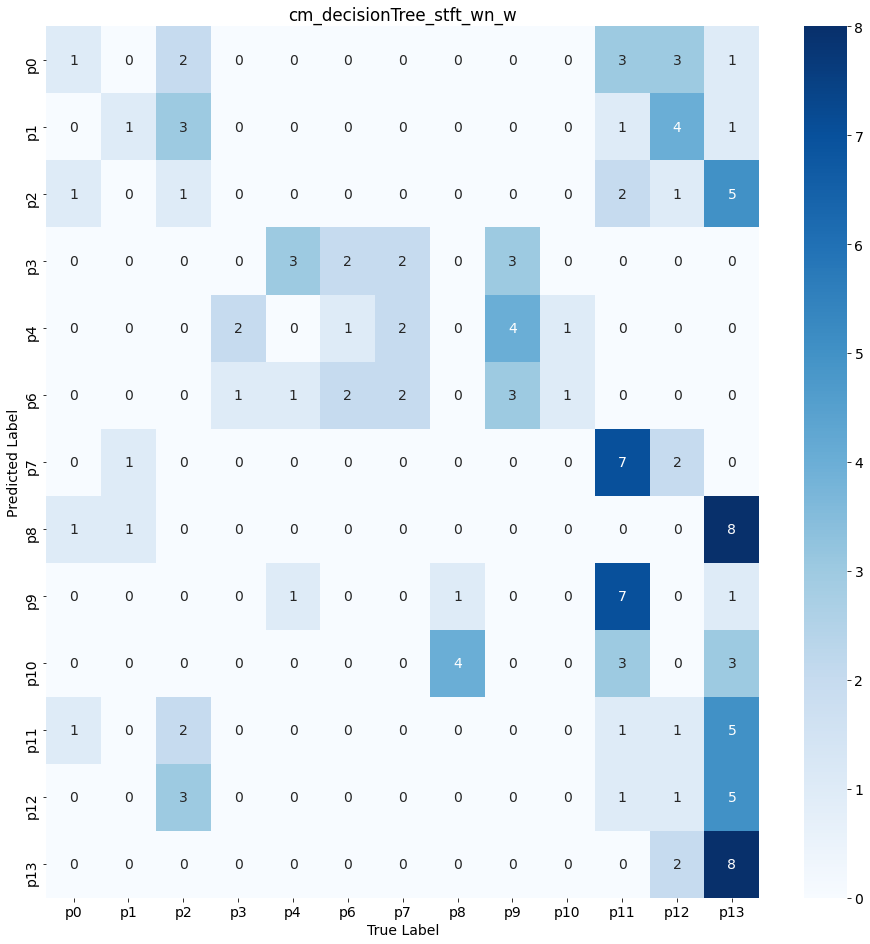

wn a stft
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.25      0.10      0.14        10
           2       0.11      0.10      0.11        10
           3       0.00      0.00      0.00        10
           4       0.25      0.10      0.14        10
           6       0.40      0.20      0.27        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.91      1.00      0.95        10
          11       0.06      0.10      0.07        10
          12       0.08      0.10      0.09        10
          13       0.15      0.60      0.24        10

    accuracy                           0.18       130
   macro avg       0.17      0.18      0.15       130
weighted avg       0.17      0.18      0.15       130

[[ 0  0  1  2  0  0  0  0  0  0  6  1  0]
 [ 1  

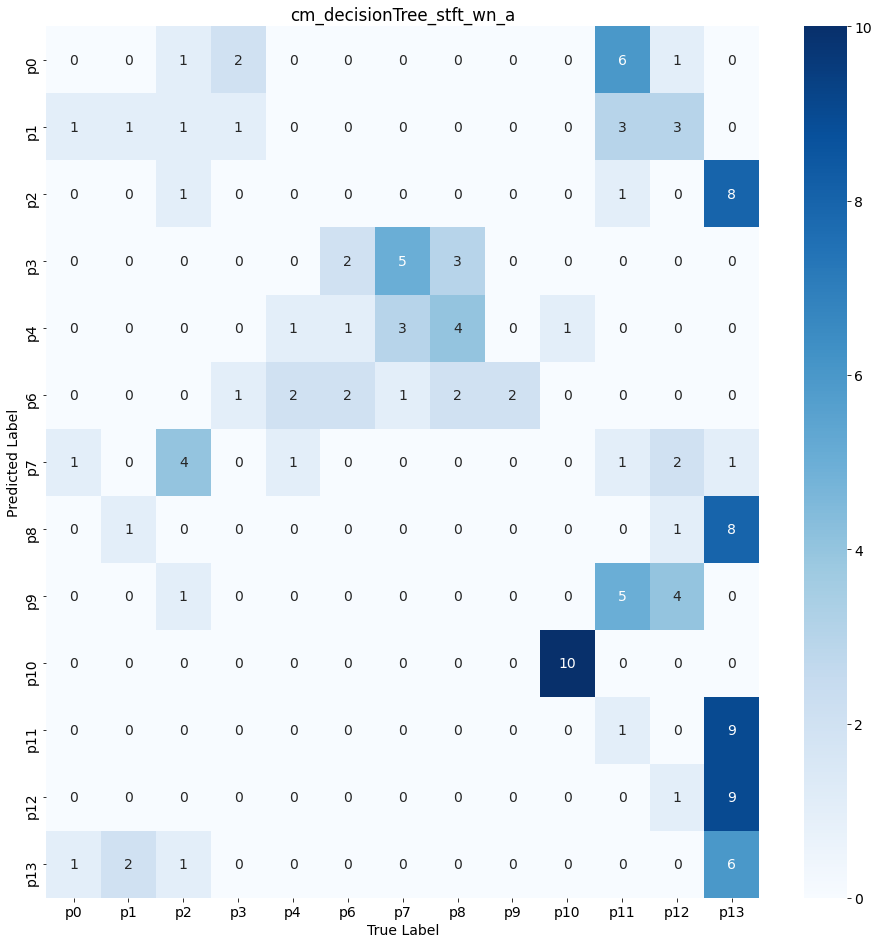

wn h stft
Accurancy:  7.6923%
              precision    recall  f1-score   support

           0       0.07      0.10      0.08        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.11      0.10      0.11        10
           4       0.14      0.10      0.12        10
           6       0.25      0.20      0.22        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      1.00      0.50        10
          11       0.00      0.00      0.00        10
          12       0.11      0.10      0.11        10
          13       0.14      0.40      0.21        10

    accuracy                           0.15       130
   macro avg       0.09      0.15      0.10       130
weighted avg       0.09      0.15      0.10       130

[[ 1  0  3  1  0  1  0  0  0  0  1  3  0]
 [ 6  0

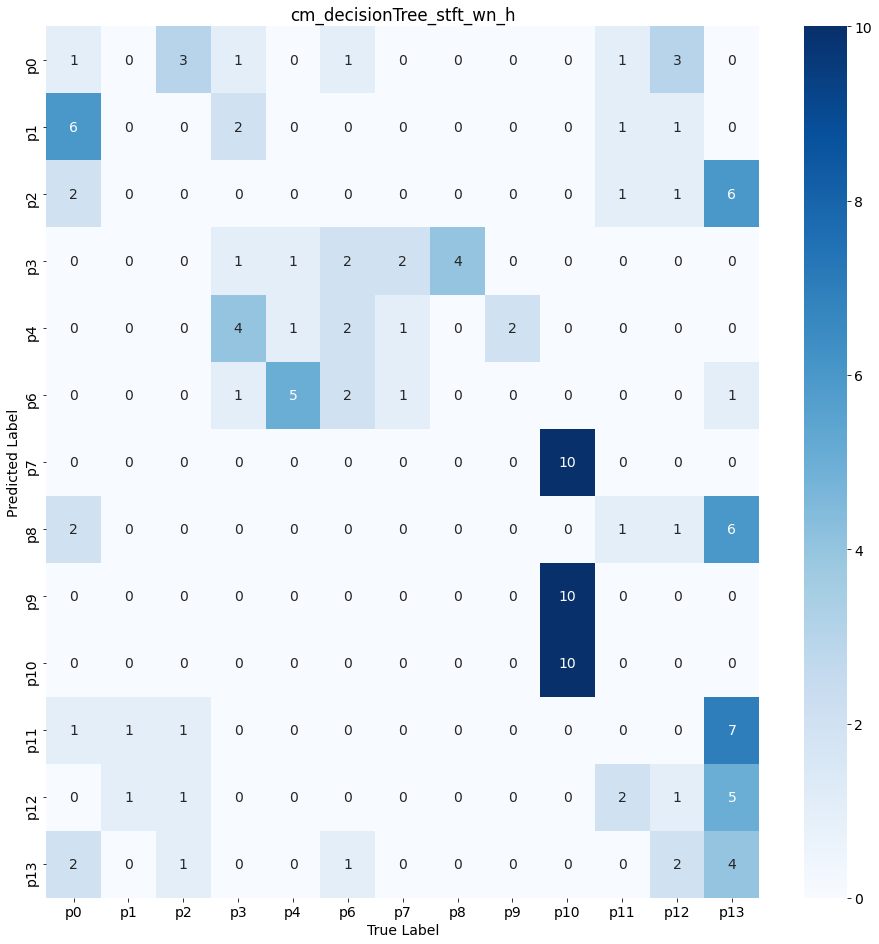

m w fft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.29      0.80      0.42        10
           3       0.80      0.40      0.53        10
           4       0.67      0.20      0.31        10
           6       0.20      0.10      0.13        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.06      0.10      0.07        10
          12       0.00      0.00      0.00        10
          13       0.12      0.50      0.19        10

    accuracy                           0.16       130
   macro avg       0.16      0.16      0.13       130
weighted avg       0.16      0.16      0.13       130

[[0 0 4 0 0 0 0 0 0 0 0 5 1]
 [0 0 1 0 0 0 0 0 0 0 

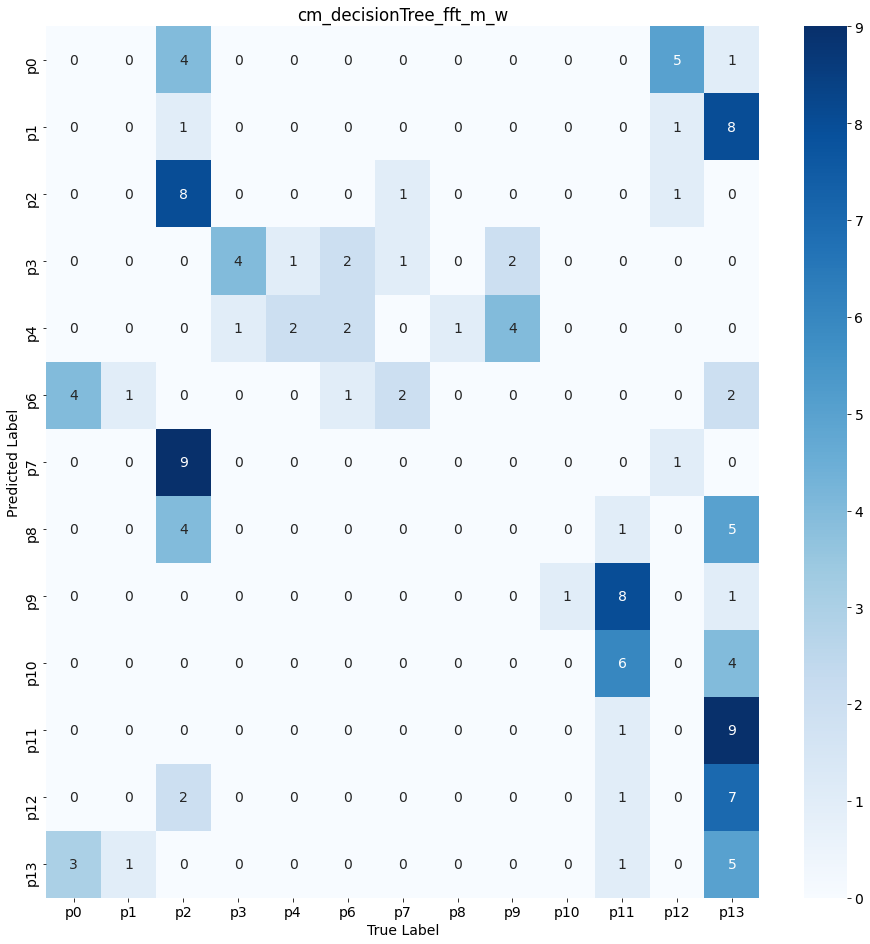

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m a fft
Accurancy:  3.0769%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.08      0.10      0.09        10
           4       0.00      0.00      0.00        10
           6       0.20      0.20      0.20        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      1.00      1.00        10
          11       0.27      0.70      0.39        10
          12       0.18      0.50      0.26        10
          13       0.00      0.00      0.00        10

    accuracy                           0.19       130
   macro avg       0.13      0.19      0.15       130
weighted avg       0.13      0.19      0.15       130

[[ 0  0  0  8  0  0  0  0  0  0  0  2  0]
 [ 0  0  

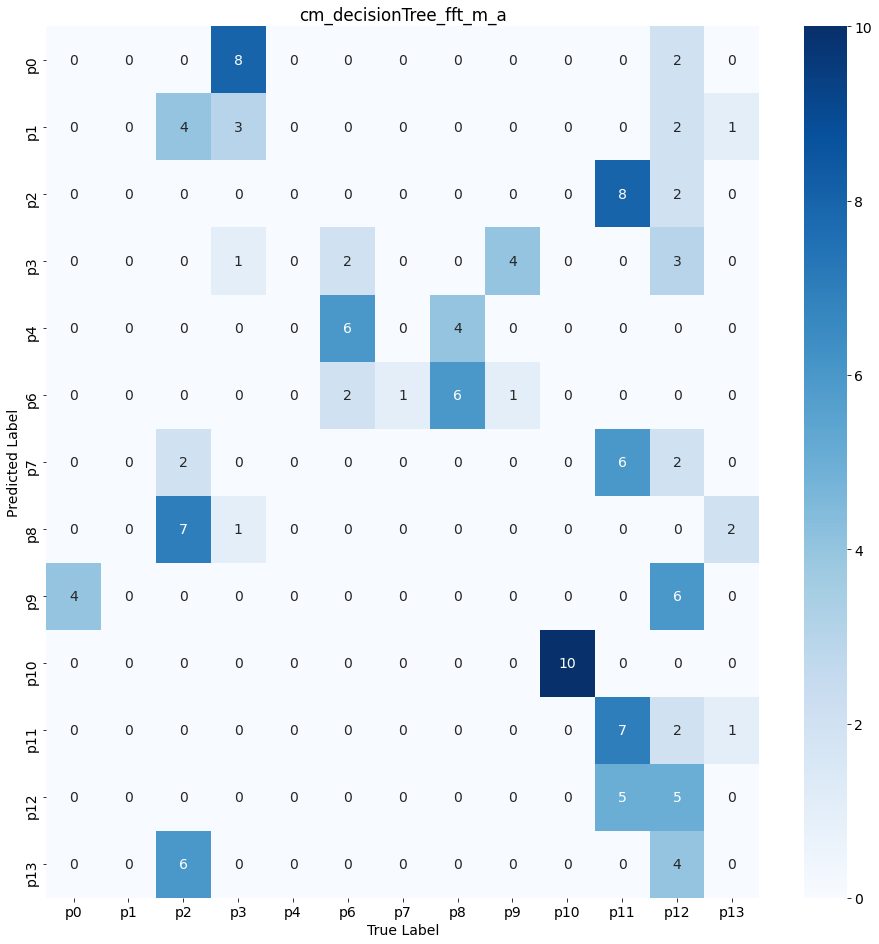

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m h fft
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.14      0.30      0.19        10
           2       0.05      0.10      0.06        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.28      0.80      0.41        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.10       130
   macro avg       0.05      0.10      0.06       130
weighted avg       0.05      0.10      0.06       130

[[ 1  1  1  0  0  0  0  0  0  0  4  3  0]
 [ 0  3  

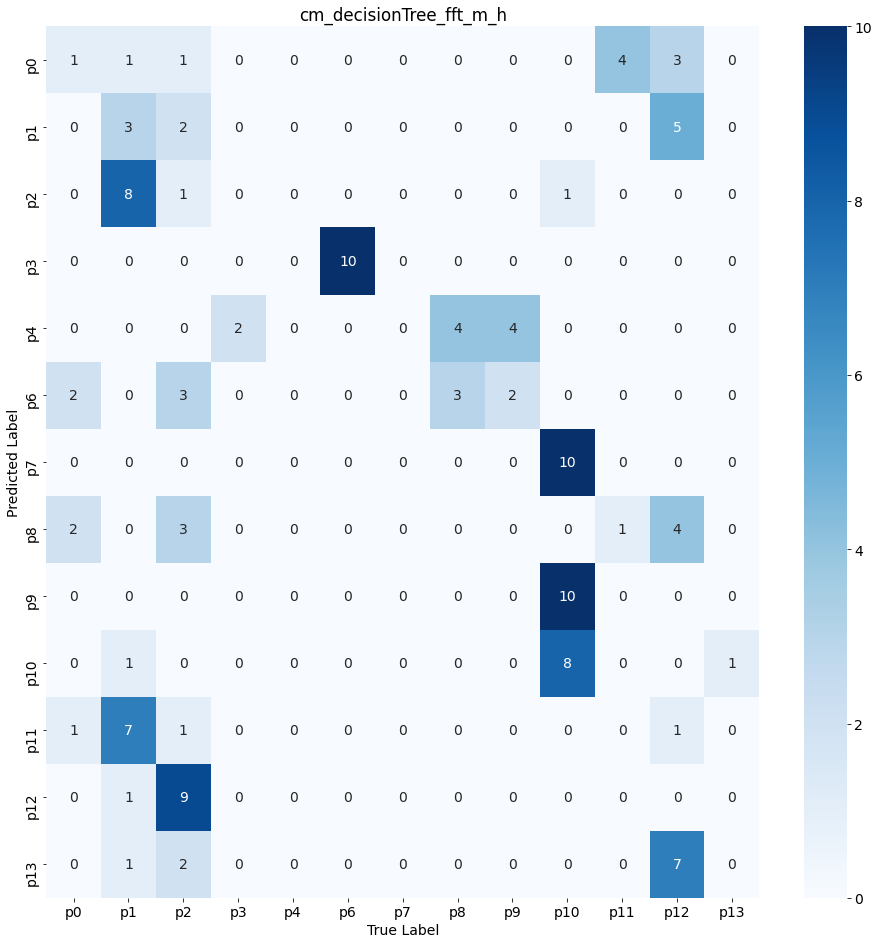

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r w fft
Accurancy:  6.1538%
              precision    recall  f1-score   support

           0       0.09      0.30      0.14        10
           1       0.00      0.00      0.00        10
           2       0.09      0.20      0.12        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.67      0.20      0.31        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.50      0.30      0.37        10

    accuracy                           0.08       130
   macro avg       0.10      0.08      0.07       130
weighted avg       0.10      0.08      0.07       130

[[ 3  6  0  0  0  1  0  0  0  0  0  0  0]
 [10  0  

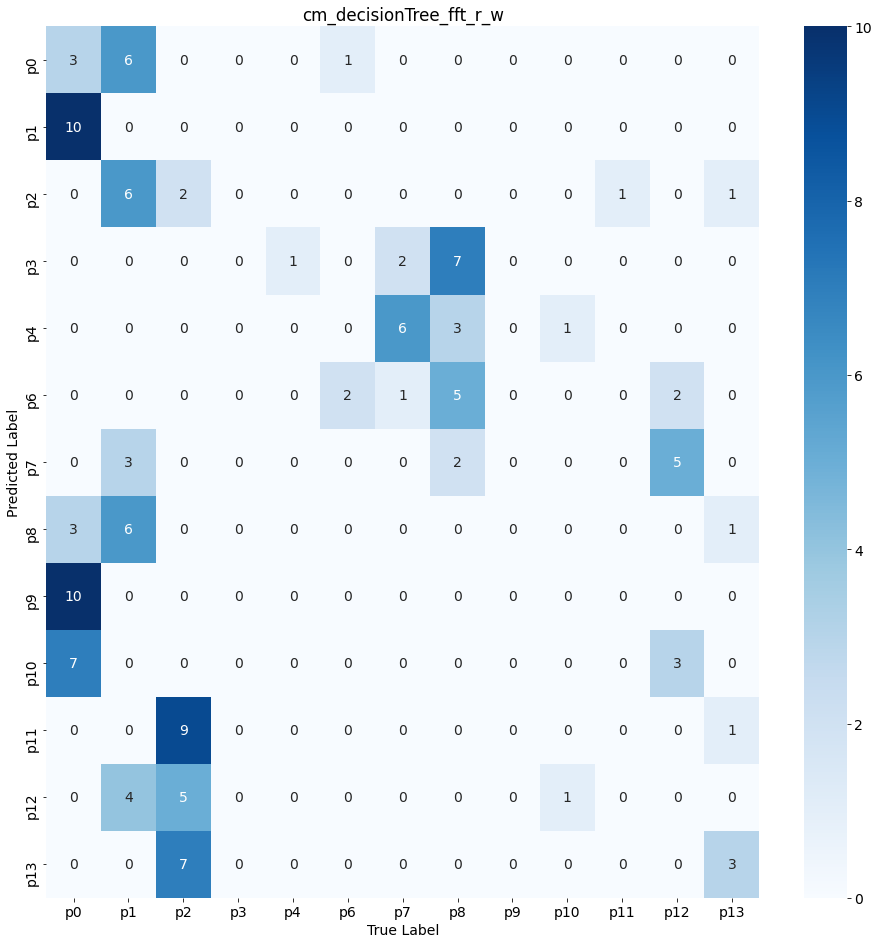

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


r a fft
Accurancy:  12.3077%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.14      0.10      0.12        10
           2       0.00      0.00      0.00        10
           3       0.50      0.30      0.37        10
           4       0.00      0.00      0.00        10
           6       0.40      0.20      0.27        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.80      0.89        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.12      0.50      0.19        10

    accuracy                           0.15       130
   macro avg       0.17      0.15      0.14       130
weighted avg       0.17      0.15      0.14       130

[[0 1 1 0 2 0 0 0 2 0 4 0 0]
 [0 1 3 0 2 0 0 0 0 0

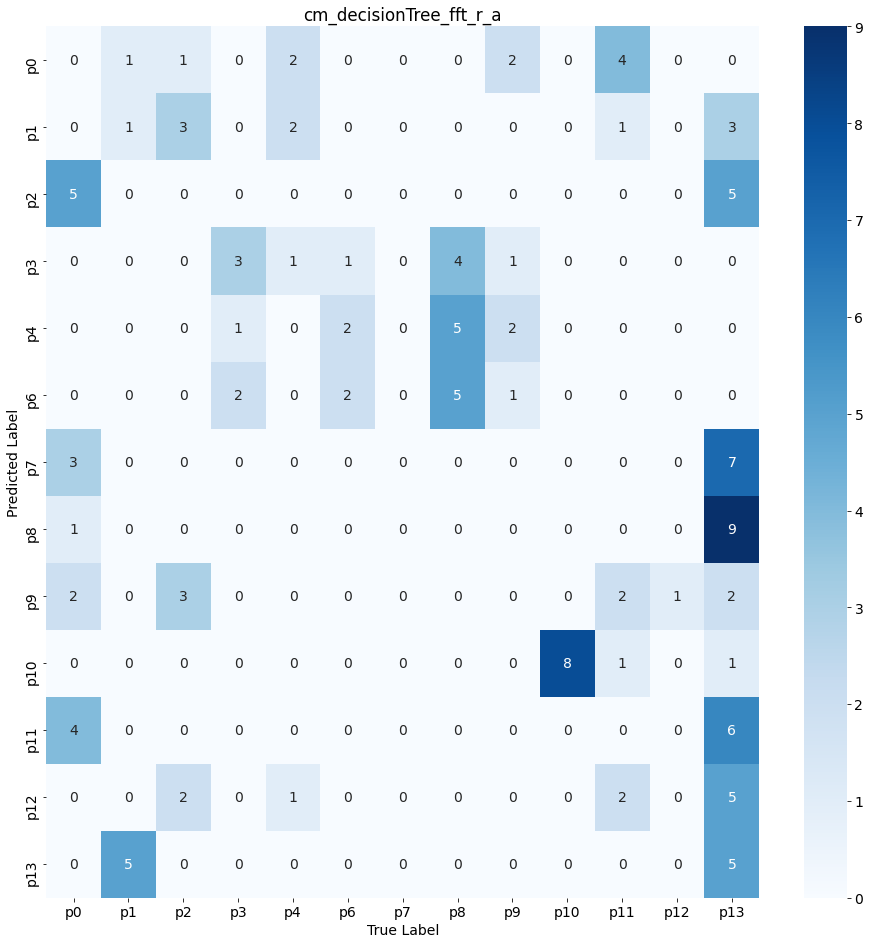

r h fft
Accurancy:  5.3846%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      0.30      0.46        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.33      0.10      0.15        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.34      1.00      0.51        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.11       130
   macro avg       0.13      0.11      0.09       130
weighted avg       0.13      0.11      0.09       130

[[ 0  0  0  0  0  0  0  0  0  0  4  0  6]
 [ 3  3  

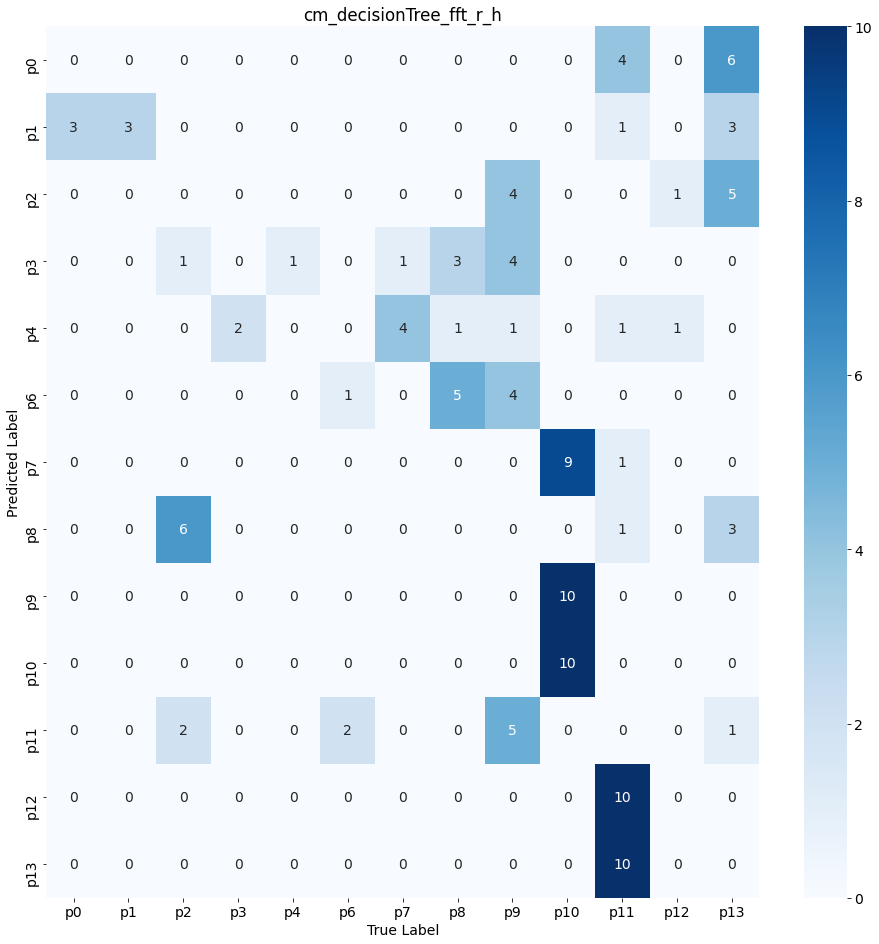

wn w fft
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.09      0.40      0.15        10
           3       0.00      0.00      0.00        10
           4       0.33      0.10      0.15        10
           6       0.44      0.40      0.42        10
           7       0.00      0.00      0.00        10
           8       0.17      0.10      0.12        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.17      0.50      0.26        10
          13       0.00      0.00      0.00        10

    accuracy                           0.12       130
   macro avg       0.09      0.12      0.08       130
weighted avg       0.09      0.12      0.08       130

[[0 0 7 0 0 0 0 0 0 0 1 2 0]
 [0 0 5 0 0 0 0 0 0 

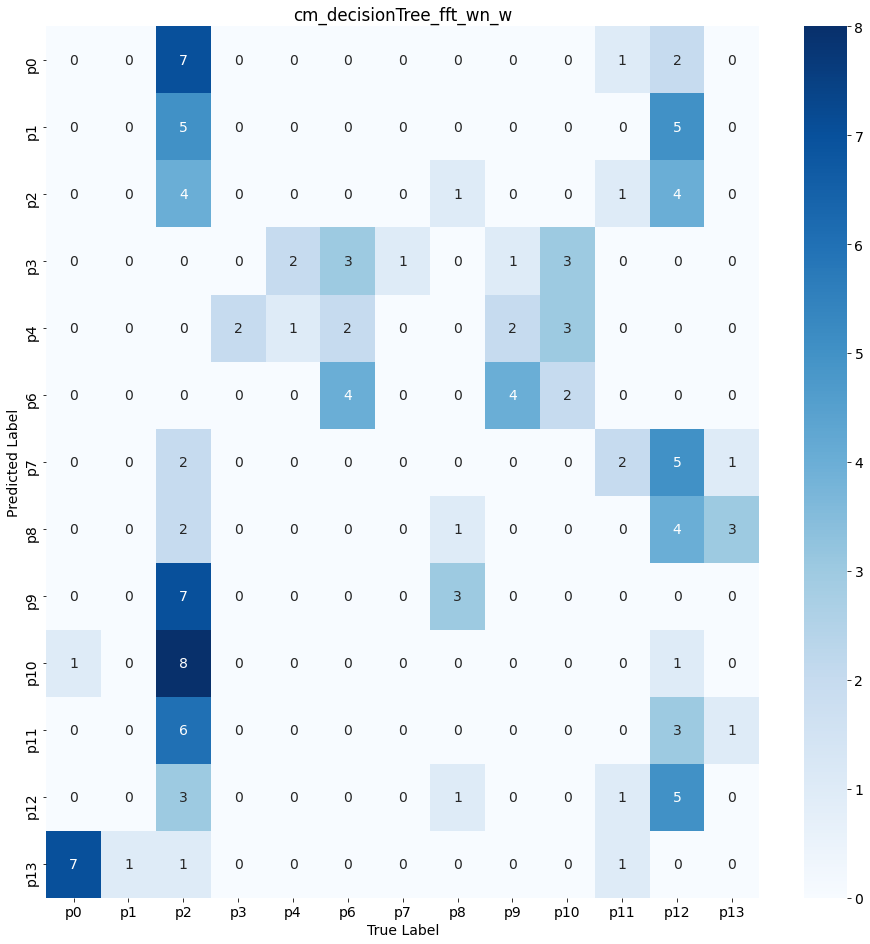

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn a fft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11      0.10      0.11        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.14      0.10      0.12        10
           6       0.33      0.60      0.43        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.10      0.40      0.16        10
          12       0.26      0.60      0.36        10
          13       0.25      0.30      0.27        10

    accuracy                           0.16       130
   macro avg       0.09      0.16      0.11       130
weighted avg       0.09      0.16      0.11       130

[[0 0 1 1 0 1 0 0 0 0 5 2 0]
 [0 1 1 1 1 0 0 0 0 0

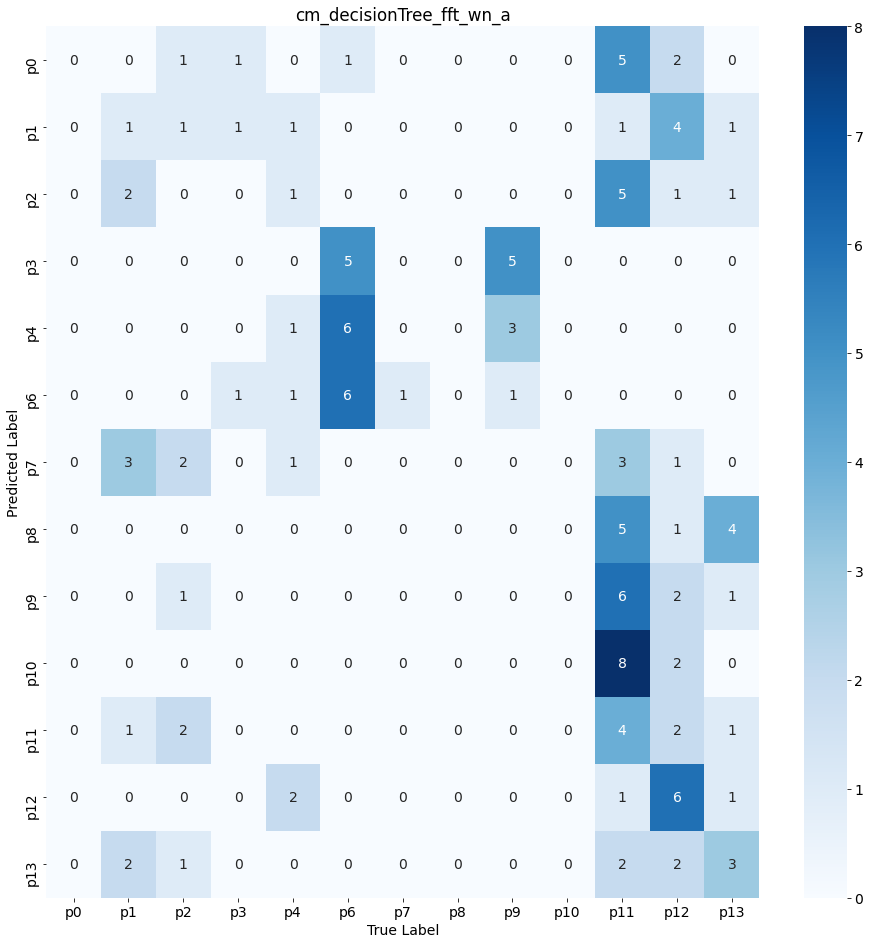

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn h fft
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.23      0.60      0.33        10
           2       0.18      0.70      0.29        10
           3       0.33      0.20      0.25        10
           4       0.19      0.30      0.23        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.50      0.40      0.44        10
          11       0.06      0.10      0.08        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.18       130
   macro avg       0.11      0.18      0.12       130
weighted avg       0.11      0.18      0.12       130

[[0 0 7 0 0 0 0 0 0 0 3 0 0]
 [0 6 0 0 0 0 0 0 0 0

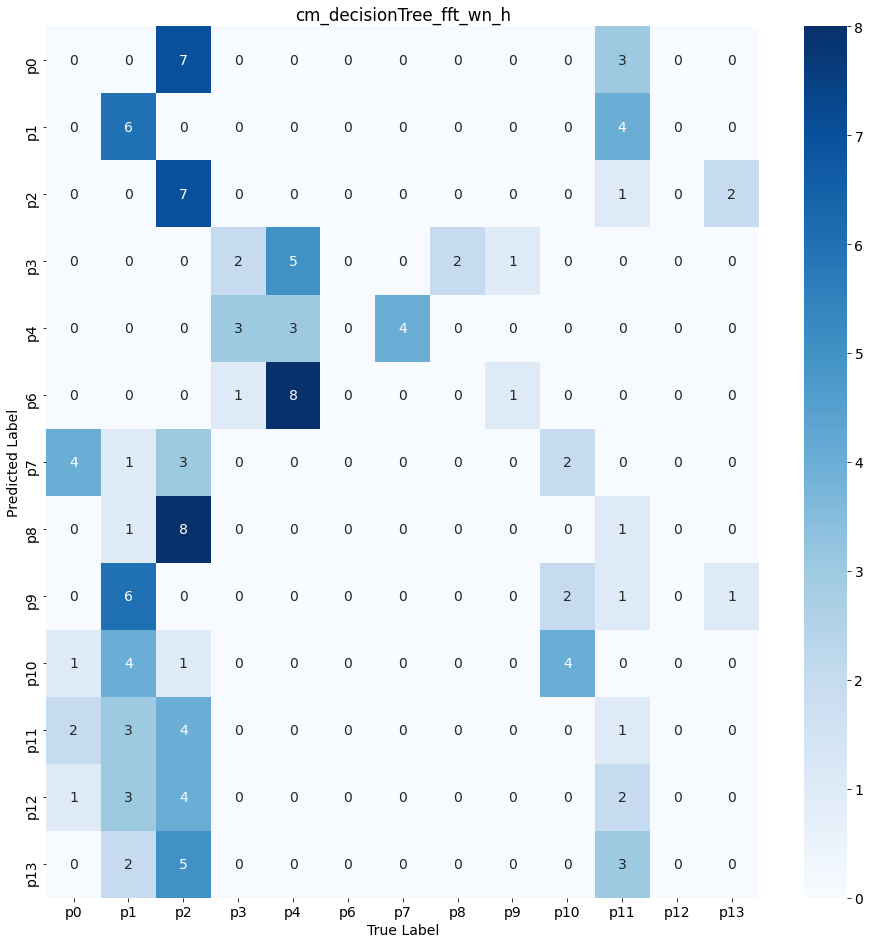

m w mfcc
Accurancy:  7.6923%
              precision    recall  f1-score   support

           0       0.35      0.60      0.44        10
           1       0.56      0.50      0.53        10
           2       0.56      0.50      0.53        10
           3       0.50      0.30      0.37        10
           4       0.17      0.10      0.12        10
           6       0.20      0.10      0.13        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.33      0.70      0.45        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.20      0.50      0.29        10

    accuracy                           0.25       130
   macro avg       0.22      0.25      0.22       130
weighted avg       0.22      0.25      0.22       130

[[ 6  0  0  0  1  0  0  0  0  1  1  1  0]
 [ 4  5 

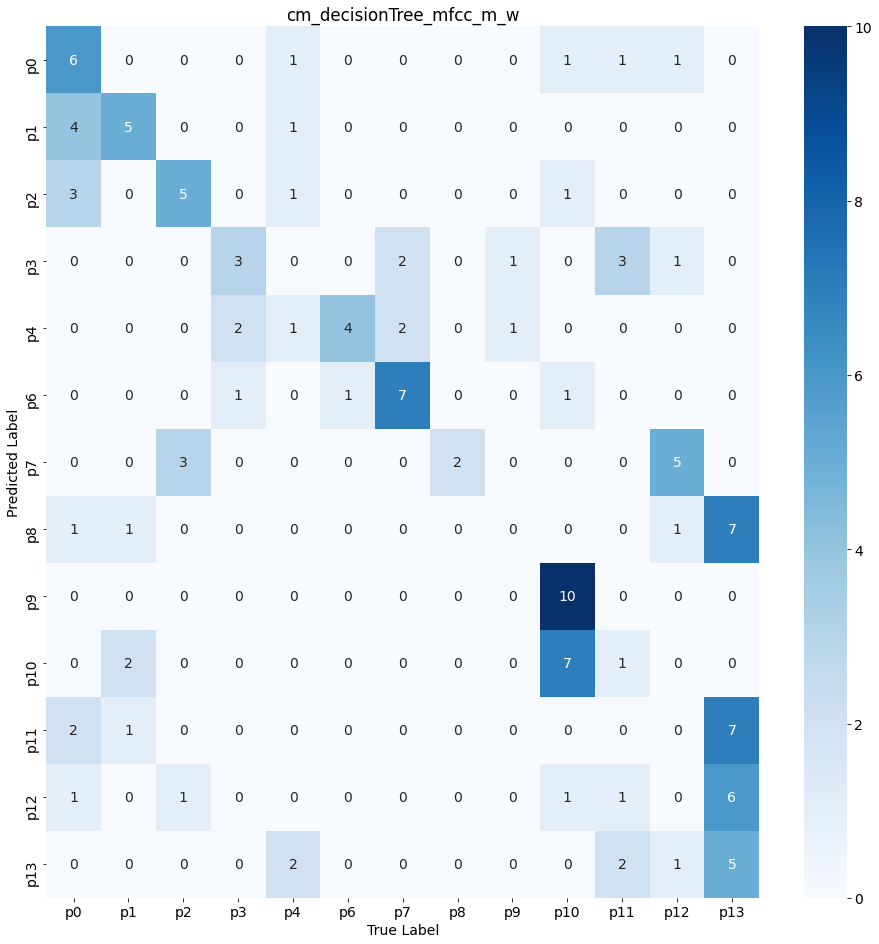

m a mfcc
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.07      0.10      0.08        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.43      0.30      0.35        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      1.00      1.00        10
          11       0.00      0.00      0.00        10
          12       0.18      0.20      0.19        10
          13       0.00      0.00      0.00        10

    accuracy                           0.12       130
   macro avg       0.13      0.12      0.12       130
weighted avg       0.13      0.12      0.12       130

[[ 1  1  3  1  0  0  0  0  0  0  2  1  1]
 [ 4  0 

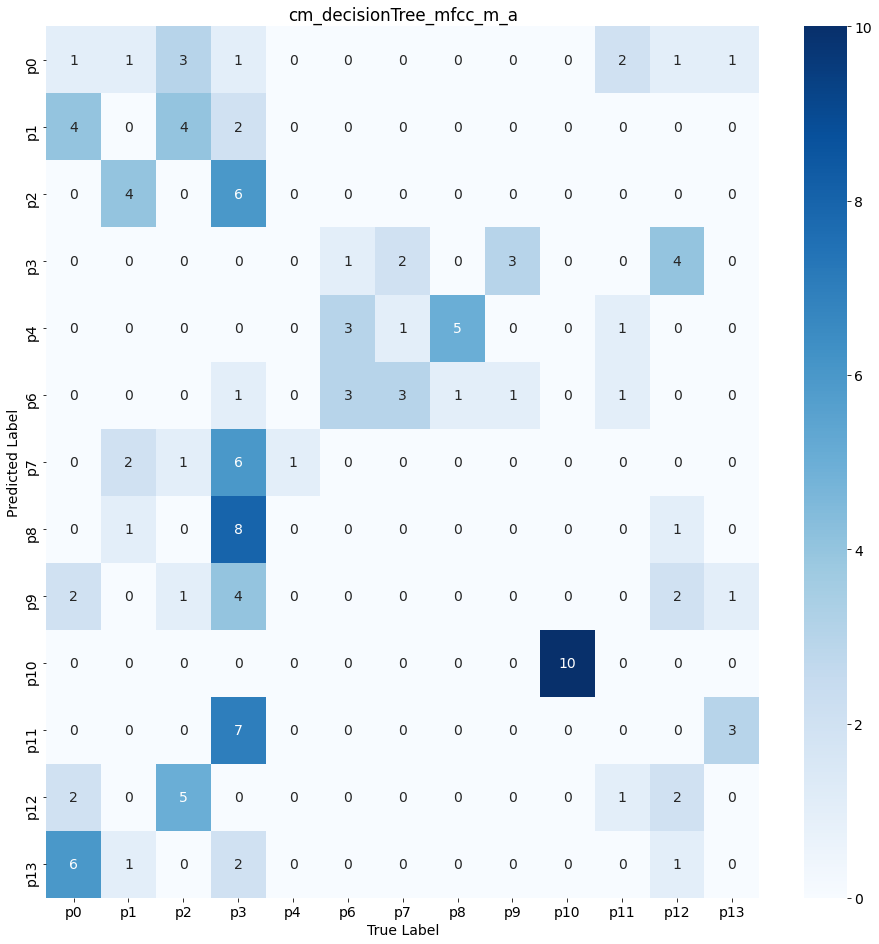

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


m h mfcc
Accurancy:  6.9231%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.53      0.80      0.64        10
           2       0.29      0.20      0.24        10
           3       0.67      0.20      0.31        10
           4       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.32      1.00      0.49        10
          11       0.00      0.00      0.00        10
          12       0.06      0.10      0.08        10
          13       0.14      0.20      0.17        10

    accuracy                           0.19       130
   macro avg       0.15      0.19      0.15       130
weighted avg       0.15      0.19      0.15       130

[[ 0  0  0  0  0  0  0  1  0  0  2  4  3]
 [ 1  8 

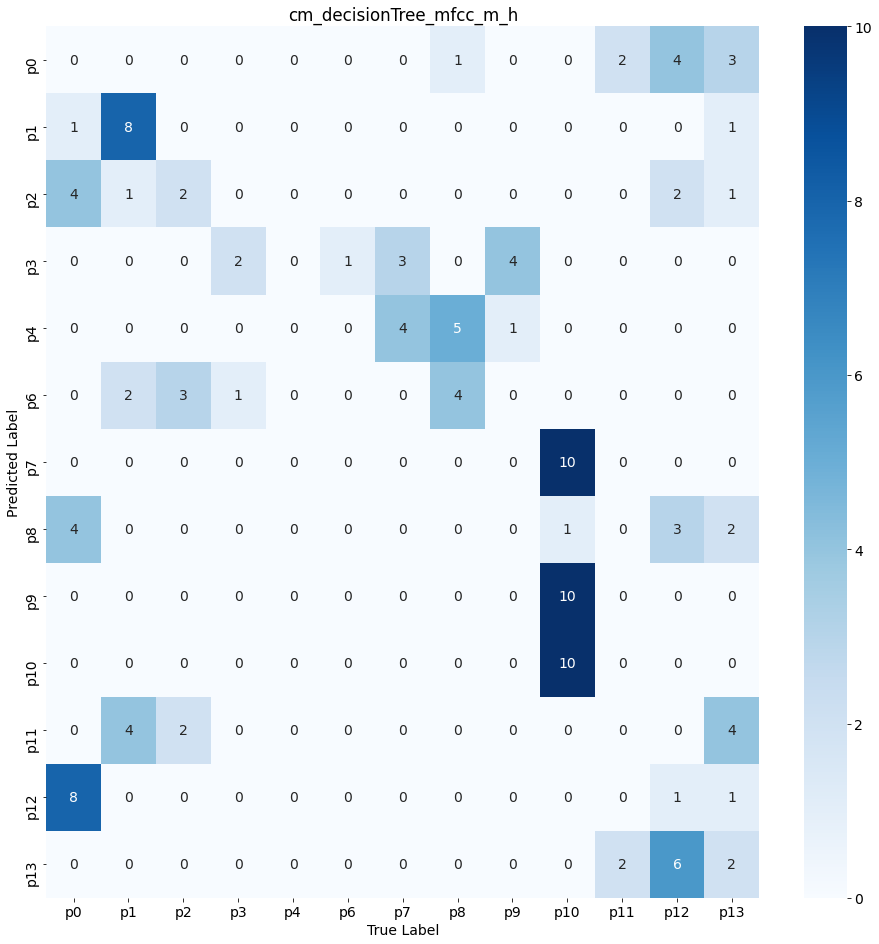

r w mfcc
Accurancy:  4.6154%
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.00      0.00      0.00        10
           2       0.17      0.40      0.24        10
           3       0.00      0.00      0.00        10
           4       0.25      0.10      0.14        10
           6       0.00      0.00      0.00        10
           7       0.12      0.10      0.11        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        10
          12       0.08      0.10      0.09        10
          13       0.37      0.70      0.48        10

    accuracy                           0.12       130
   macro avg       0.13      0.12      0.11       130
weighted avg       0.13      0.12      0.11       130

[[ 2  0  4  0  0  0  0  4  0  0  0  0  0]
 [ 0  0 

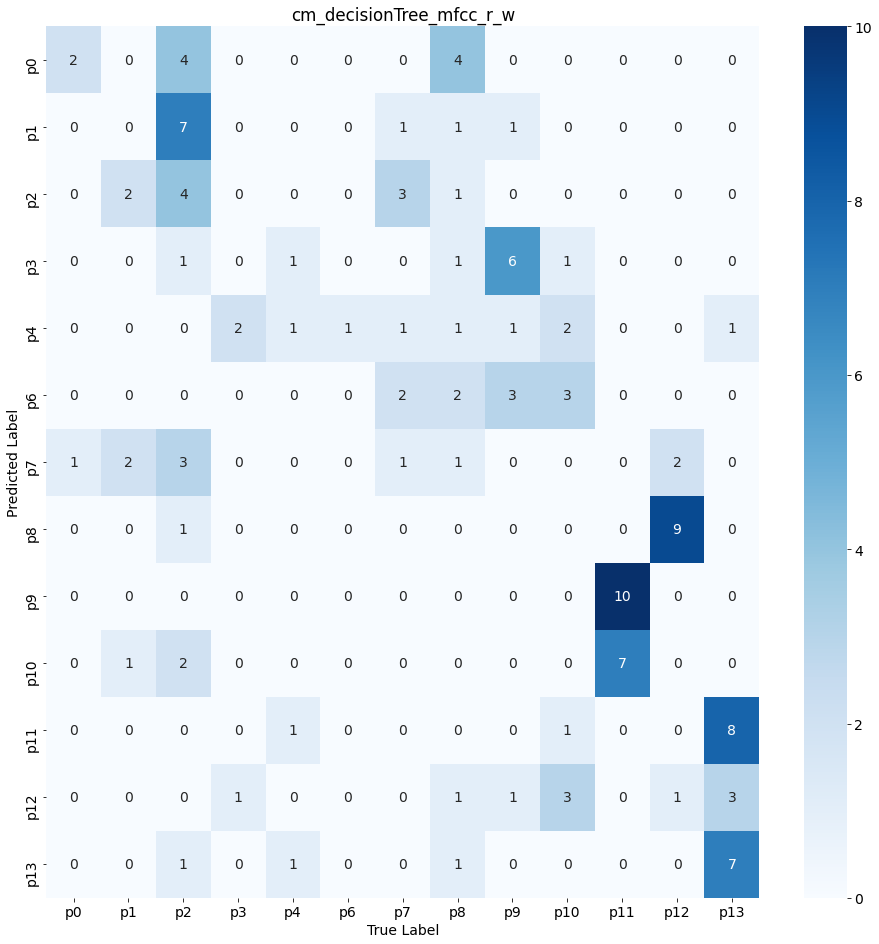

r a mfcc
Accurancy:  10.7692%
              precision    recall  f1-score   support

           0       0.14      0.30      0.19        10
           1       0.14      0.10      0.12        10
           2       0.00      0.00      0.00        10
           3       0.17      0.10      0.12        10
           4       0.00      0.00      0.00        10
           6       0.30      0.30      0.30        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      0.90      0.95        10
          11       0.00      0.00      0.00        10
          12       0.29      0.40      0.33        10
          13       0.41      0.90      0.56        10

    accuracy                           0.23       130
   macro avg       0.19      0.23      0.20       130
weighted avg       0.19      0.23      0.20       130

[[3 1 2 0 0 0 0 0 0 0 3 1 0]
 [0 1 0 0 5 1 0 0 0 

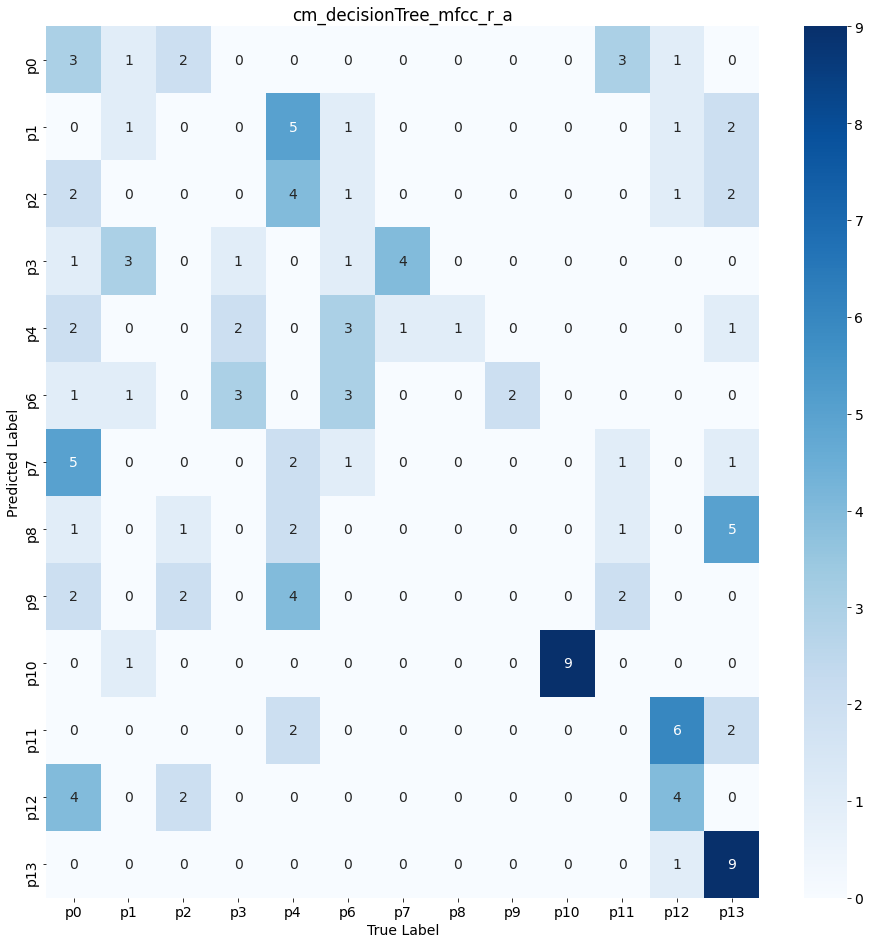

r h mfcc
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.12      0.10      0.11        10
           2       0.00      0.00      0.00        10
           3       0.33      0.10      0.15        10
           4       0.33      0.40      0.36        10
           6       0.50      0.10      0.17        10
           7       0.00      0.00      0.00        10
           8       0.17      0.10      0.12        10
           9       0.00      0.00      0.00        10
          10       0.31      0.90      0.46        10
          11       0.05      0.10      0.06        10
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00        10

    accuracy                           0.14       130
   macro avg       0.14      0.14      0.11       130
weighted avg       0.14      0.14      0.11       130

[[ 0  2  2  0  0  0  0  0  0  0  1  4  1]
 [ 0  1

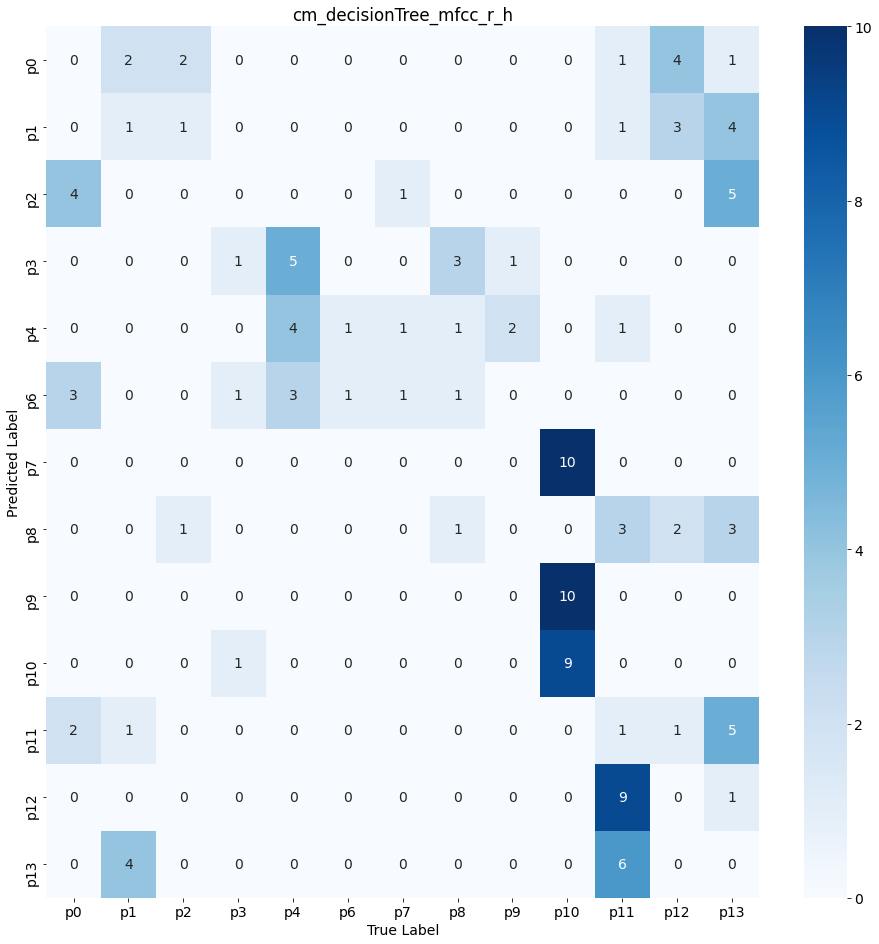

wn w mfcc
Accurancy:  10.0000%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.20      0.10      0.13        10
           2       0.09      0.10      0.10        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.09      0.10      0.10        10
          10       0.33      0.30      0.32        10
          11       0.14      0.20      0.17        10
          12       0.18      0.40      0.25        10
          13       0.08      0.10      0.09        10

    accuracy                           0.10       130
   macro avg       0.09      0.10      0.09       130
weighted avg       0.09      0.10      0.09       130

[[0 0 2 0 0 0 0 0 0 0 1 4 3]
 [5 1 1 0 0 0 0 0 0

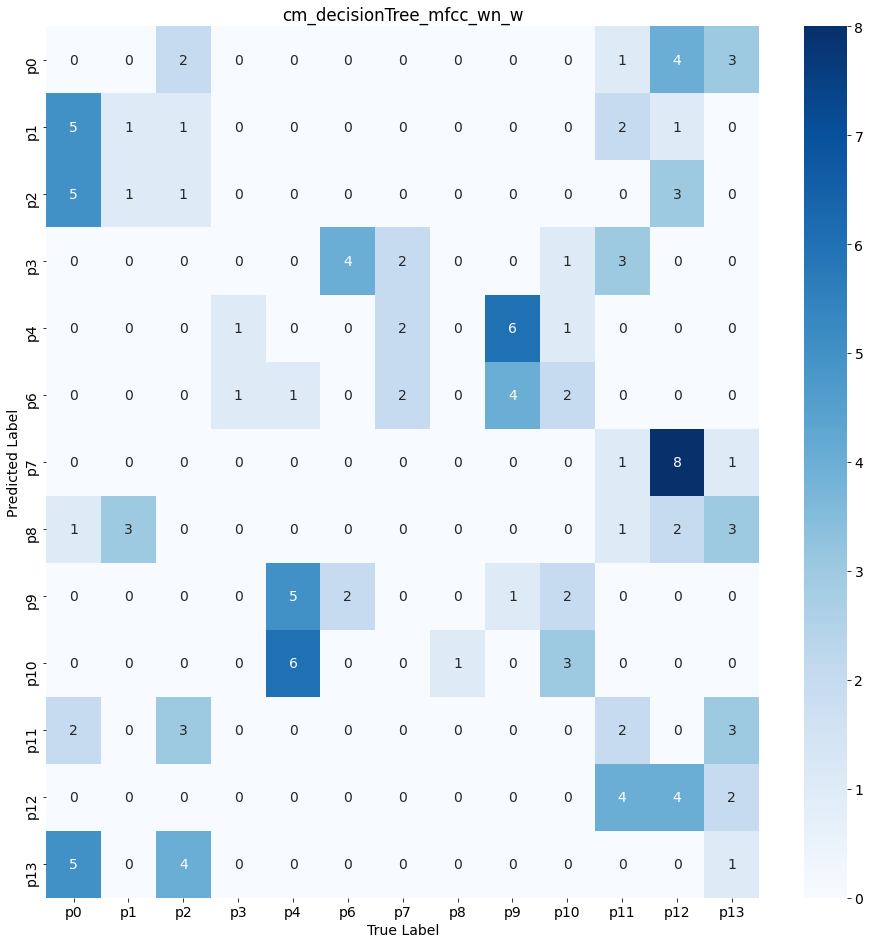

/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterhub/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wn a mfcc
Accurancy:  7.6923%
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        10
           1       0.00      0.00      0.00        10
           2       0.12      0.20      0.15        10
           3       0.17      0.20      0.18        10
           4       0.00      0.00      0.00        10
           6       0.83      0.50      0.62        10
           7       0.12      0.10      0.11        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       1.00      1.00      1.00        10
          11       0.29      0.20      0.24        10
          12       0.20      0.30      0.24        10
          13       0.26      0.60      0.36        10

    accuracy                           0.25       130
   macro avg       0.24      0.25      0.23       130
weighted avg       0.24      0.25      0.23       130

[[ 1  3  0  0  3  0  0  0  0  0  2  1  0]
 [ 4  0

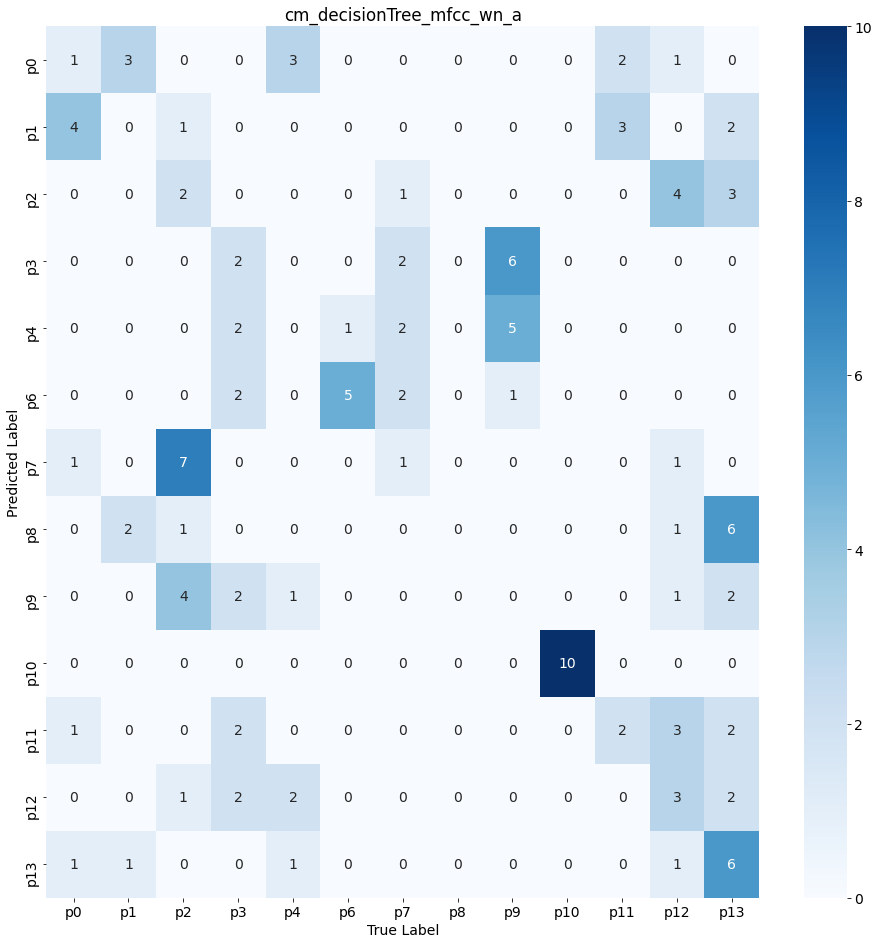

wn h mfcc
Accurancy:  3.8462%
              precision    recall  f1-score   support

           0       0.09      0.10      0.10        10
           1       0.15      0.20      0.17        10
           2       0.12      0.10      0.11        10
           3       0.60      0.30      0.40        10
           4       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10
          10       0.26      1.00      0.42        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.03      0.10      0.05        10

    accuracy                           0.14       130
   macro avg       0.10      0.14      0.10       130
weighted avg       0.10      0.14      0.10       130

[[ 1  3  4  0  0  0  0  0  0  0  1  0  1]
 [ 1  2

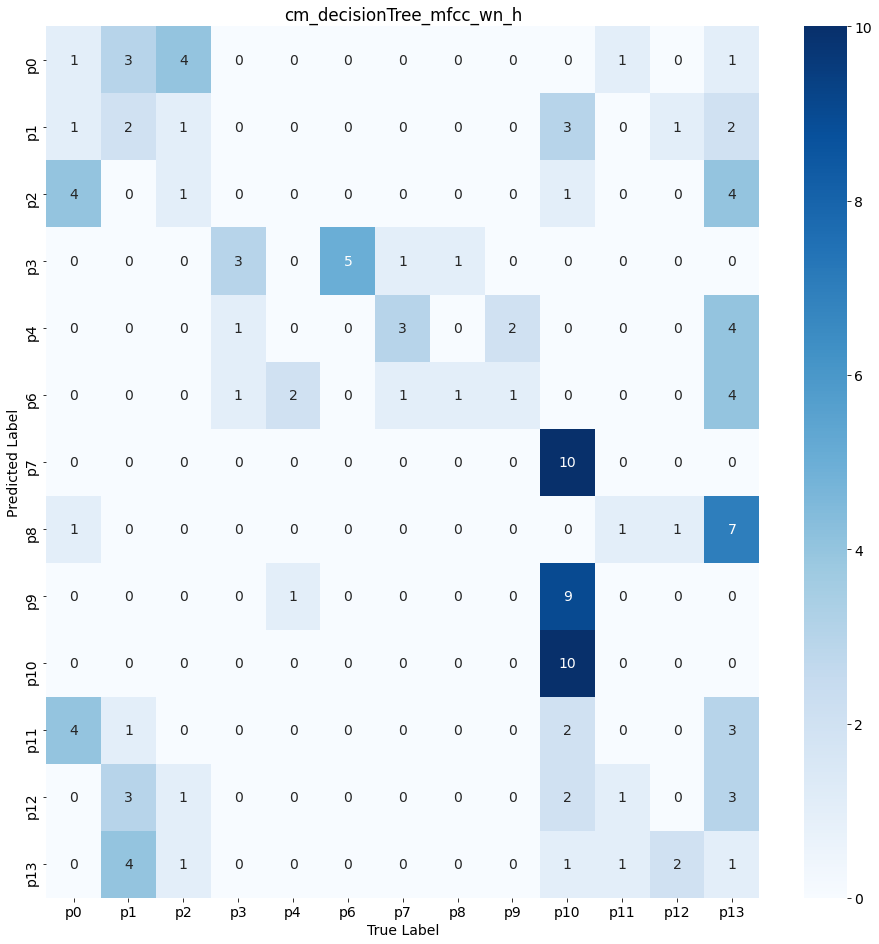

In [198]:
"""USES DECISION TREE"""
for t in ['stft', 'fft', 'mfcc']:
    for stimulus in ['m', 'r', 'wn']:
        for position in ['w', 'a', 'h']:

            x_train = np.array([d[t].flatten() for d in _dataset
                                 if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            x_val = np.array([d[t].flatten() for d in _dataset
                                 if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_train  = np.array([d['pid'] for d in _dataset
                                  if d['pid'] != 5 and d['session'] == 0 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            y_val  = np.array([d['pid'] for d in _dataset
                                  if d['pid'] != 5 and d['session'] == 1 and d['stimulus_type'] == stimulus and d['location'] == position])
            
            clf = DecisionTreeClassifier(random_state=0)
            clf.fit(x_train, y_train)

            y_pred = clf.predict(x_val)

            report = classification_report(y_val, y_pred)
            cm = confusion_matrix(y_val, y_pred)

            print(stimulus, position, t)

            print(report)
            print(cm)

            labels = ["p0", "p1", "p2", "p3", "p4", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13"]

            df_cm = pd.DataFrame(cm, index = labels, columns = labels)
            plt.figure(figsize= (13,13))
            sn_plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
            plt.title(f'cm_decisionTree_{t}_{stimulus}_{position}')
            plt.xlabel("True Label")
            plt.ylabel("Predicted Label")
            plt.tight_layout(pad=0.2)
            plt.savefig(f'./Plots/Confusion Matrix/cm_decisionTree_{t}_{stimulus}_{position}.pdf')
            plt.show()
 

In [200]:
def plot_stft(set_entry):   
    """
    Takes an entry of the dataframe and prints the spectogram related to the entries stft data.
    
    :param set_entry: The entry from the dataset.
    """
    
    d = set_entry
    
    Xdb = lb.amplitude_to_db(d['stft'], ref=np.max)
    #plt.figure(figsize=(14, 6))
    librosa.display.specshow(Xdb, sr=d['samplerate'], x_axis='time', y_axis='hz')
    plt.ylim(0, 8000)
    plt.title(f"stft_p{d['pid']}_s{d['session']}_{d['location']}_{d['stimulus_type']}_{d['repetition']}")
    plt.colorbar(format="%+2.0f dB")

    #plt.axis('off')
    plt.tight_layout(pad=0.0)
    plt.savefig(f"./Plots/STFT/stft_p{d['pid']}_s{d['session']}_{d['location']}_{d['stimulus_type']}_{d['repetition']}.pdf")
    plt.clf()

  

In [201]:
""" Takes the number of hardware ressources specified in n_jobs and executes the plotting function parallel on those ressources. """

from joblib import Parallel, delayed

Parallel(n_jobs=-1)(delayed(plot_stft)(d) for d in _dataset)



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,